In [1]:
from copy import deepcopy
import datetime
import numpy as np
import pandas as pd
import os
import sys
from importlib import reload
import matplotlib.pyplot as plt
import seaborn as sns
sys.path.append('..')

This notebook replicates some results of _Lifecycle Investing_'s excel simulations, found on their website.

In [2]:
def make_tall_dataframe(s1):
    """
    Turns a simulation object into a tall dataframe which holds all
    the important data columns.
    """
    
    s1 = deepcopy(s1)
    
    # portfolio value
    df1 = s1.rsbp. \
        copy(). \
        rename(columns={'Final': 529, 'FINAL':529})
    
    if (0 not in s1.rsbp.columns):
        df1.insert(loc=3, column=0, value=0.0)
    
    df1.insert(loc=3, column='lambda_start', value=s1.percentage_target.loc[0,1])
    df1.insert(loc=4, column='lambda_end', value=s1.percentage_target.loc[0,528])
    try:
        df1.insert(loc=5, column='lambda1', value=s1.lambda1)
        df1.insert(loc=6, column='lambda2', value=s1.lambda2)
        lambda1 = '_' + str(round(s1.lambda1,2))
        lambda2 = '_' + str(round(s1.lambda2,2))
        
    except AttributeError:
        # simulation does not have lambdas
        df1.insert(loc=5, column='lambda1', value=None)
        df1.insert(loc=6, column='lambda2', value=None)  
        lambda1 = ''
        lambda2 = ''

    df1a = df1.melt(id_vars=['cohort_num', 'begins_work','retire','lambda_start', 'lambda_end', 'lambda1', 'lambda2'], 
                    value_vars=None, 
                    var_name=None, 
                    value_name='port_value').\
        rename(columns={'variable': 'period_num'})

    # percentage target
    df1b = s1.percentage_target.copy()
    if (0 not in s1.rsbp.columns):
        df1b.insert(loc=3, column=0, value=0.0)
    df1b.insert(loc=3, column='lambda_start', value=s1.percentage_target.loc[0,1])
    df1b.insert(loc=4, column='lambda_end', value=s1.percentage_target.loc[0,528])
    try:
        df1b.insert(loc=5, column='lambda1', value=s1.lambda1)
        df1b.insert(loc=6, column='lambda2', value=s1.lambda2)
        
    except AttributeError:
        # simulation does not have lambdas
        df1b.insert(loc=5, column='lambda1', value=None)
        df1b.insert(loc=6, column='lambda2', value=None)

    df1c = df1b.melt(id_vars=['cohort_num', 'begins_work','retire','lambda_start', 'lambda_end', 'lambda1', 'lambda2'], 
                     value_vars=None, 
                     var_name=None, 
                     value_name='perc_targ').\
        rename(columns={'variable': 'period_num'})

    df1d = pd.merge(df1a, 
                    df1c, 
                    on=['cohort_num', 'begins_work','retire','lambda_start', 'lambda_end', 'period_num', 'lambda1', 'lambda2'],
                    how='left')

    # monthly returns
    df1e = pd.melt(s1.data_month, 
                   id_vars=['cohort_num', 'begins_work', 'retire'],
                   var_name='period_num',
                   value_name='month')

    df1f = pd.merge(df1e, 
                   s1.monthly_data.loc[:, ['Months_beginning_Jan_1871', 
                                             'Monthly_real_gov_bond_rate', # L
                                             'Monthly_real_margin_rate', # M
                                             'Monthly_real_stock_rate', # N
                                             'Margin_Call_Cutoff', # P
                                             'Margin_Call_Real_Stock_Return']], # Q
                   left_on='month',
                   right_on='Months_beginning_Jan_1871'). \
      sort_values(['cohort_num', 'period_num', 'begins_work'])

    df1g = pd.merge(df1d,
                    df1f,
                    on=['cohort_num', 'begins_work', 'retire', 'period_num'],
                    how='left'). \
        sort_values(['cohort_num', 'lambda_start', 'lambda_end', 'period_num'])
    
#     df1g.loc[:, 'strategy'] = str(round(100*df1g['lambda_start'][0])) + '/' + str(round(100*df1g['lambda_end'][0]))
    
    df1g.insert(loc=7, 
                column='strategy', 
                value=str(round(100*df1g['lambda_start'][0])) + '/' + str(round(100*df1g['lambda_end'][0])) + 
                        lambda1 + lambda2)
    
    return df1g.copy()

In [4]:
# replicate the birthday rule backtest
import lc_investing.birthday_rule
lc_investing.birthday_rule = reload(lc_investing.birthday_rule)

s1 = lc_investing.birthday_rule.Simulation(data_folder='../lc_investing/data/')
s1.rsbp.Final.describe()

df1 = make_tall_dataframe(s1)
df1.head()

cohort_num  begins_work  retire  lambda_start  lambda_end lambda1  \
0             1         1871    1914           0.9    0.500758    None   
96            1         1871    1914           0.9    0.500758    None   
192           1         1871    1914           0.9    0.500758    None   
288           1         1871    1914           0.9    0.500758    None   
384           1         1871    1914           0.9    0.500758    None   

    lambda2 strategy period_num  port_value perc_targ  month  \
0      None    90/50          0    0.000000       0.0    NaN   
96     None    90/50          1  157.453664       0.9    1.0   
192    None    90/50          2  311.004722  0.899242    2.0   
288    None    90/50          3  474.210363  0.898485    3.0   
384    None    90/50          4  675.569397  0.897727    4.0   

     Months_beginning_Jan_1871  Monthly_real_gov_bond_rate  \
0                          NaN                         NaN   
96                         1.0                   -0.017899   
192                        2.0                   -0.005142   
288                        3.0                    0.047218   
384                        4.0                    0.029103   

     Monthly_real_margin_rate  Monthly_real_stock_rate  Margin_Call_Cutoff  \
0                         NaN                      NaN                 NaN   
96                  -0.024531                -0.011781                 3.0   
192                 -0.011273                 0.014230                 3.0   
288                  0.041445                 0.072026                 3.0   
384                  0.028105                 0.053836                 3.0   

     Margin_Call_Real_Stock_Return  
0                              NaN  
96                       -0.029629  
192                      -0.014602  
288                       0.037880  
384                       0.023254

In [5]:
# replicate the constant percent stock backtest
import lc_investing.constant_percent_stock
lc_investing.constant_percent_stock = reload(lc_investing.constant_percent_stock)

s2 = lc_investing.constant_percent_stock.Simulation(data_folder='../lc_investing/data/')
s2.rsbp.Final.describe()

df2 = make_tall_dataframe(s2)
df2.head()

cohort_num  begins_work  retire  lambda_start  lambda_end lambda1  \
0             1         1871    1914          0.75        0.75    None   
96            1         1871    1914          0.75        0.75    None   
192           1         1871    1914          0.75        0.75    None   
288           1         1871    1914          0.75        0.75    None   
384           1         1871    1914          0.75        0.75    None   

    lambda2 strategy period_num  port_value  perc_targ  month  \
0      None    75/75          0    0.000000       0.00    NaN   
96     None    75/75          1  157.453664       0.75    1.0   
192    None    75/75          2  310.715737       0.75    2.0   
288    None    75/75          3  472.564225       0.75    3.0   
384    None    75/75          4  671.488074       0.75    4.0   

     Months_beginning_Jan_1871  Monthly_real_gov_bond_rate  \
0                          NaN                         NaN   
96                         1.0                   -0.017899   
192                        2.0                   -0.005142   
288                        3.0                    0.047218   
384                        4.0                    0.029103   

     Monthly_real_margin_rate  Monthly_real_stock_rate  Margin_Call_Cutoff  \
0                         NaN                      NaN                 NaN   
96                  -0.024531                -0.011781                 3.0   
192                 -0.011273                 0.014230                 3.0   
288                  0.041445                 0.072026                 3.0   
384                  0.028105                 0.053836                 3.0   

     Margin_Call_Real_Stock_Return  
0                              NaN  
96                       -0.029629  
192                      -0.014602  
288                       0.037880  
384                       0.023254

In [6]:
# replicate the lifecycle strategy backtest
import lc_investing.lifecycle_strategy
lc_investing.lifecycle_strategy = reload(lc_investing.lifecycle_strategy)

s3 = lc_investing.lifecycle_strategy.Simulation()
s3.calc_retirement_savings_before_period()
s3.rsbp.FINAL.describe()

df3 = make_tall_dataframe(s3)  # df3.lambda_end==0.83030407
df3.head(3)

cohort_num  begins_work  retire  lambda_start  lambda_end   lambda1  \
0             1         1871    1914           2.0    0.830304  0.830304   
96            1         1871    1914           2.0    0.830304  0.830304   
192           1         1871    1914           2.0    0.830304  0.830304   

      lambda2          strategy period_num  port_value  perc_targ  month  \
0    0.830304  200/83_0.83_0.83          0    0.000000        0.0    NaN   
96   0.830304  200/83_0.83_0.83          1  157.453664        2.0    1.0   
192  0.830304  200/83_0.83_0.83          2  315.212525        2.0    2.0   

     Months_beginning_Jan_1871  Monthly_real_gov_bond_rate  \
0                          NaN                         NaN   
96                         1.0                   -0.017899   
192                        2.0                   -0.005142   

     Monthly_real_margin_rate  Monthly_real_stock_rate  Margin_Call_Cutoff  \
0                         NaN                      NaN                 NaN   
96                  -0.024531                -0.011781                 3.0   
192                 -0.011273                 0.014230                 3.0   

     Margin_Call_Real_Stock_Return  
0                              NaN  
96                       -0.029629  
192                      -0.014602

In [8]:
import lc_investing.constant_percent_stock
lc_investing.constant_percent_stock = reload(lc_investing.constant_percent_stock)

s4 = lc_investing.constant_percent_stock.Simulation(data_folder='../lc_investing/data/',
                                                    #bondadj=0,
                                                    #margadj=0,
                                                    #stockadj=0,
                                                    lambdacons=1, # stock allocation
                                                    #start_age=23,
                                                    #start_amt=1,
                                                    #max_rate = np.Inf,
                                                    #borrowing_rate_override=None
                                                   )
df4 = make_tall_dataframe(s4)

s5 = lc_investing.constant_percent_stock.Simulation(data_folder='../lc_investing/data/',
                                                    #bondadj=0,
                                                    #margadj=0,
                                                    #stockadj=0,
                                                    lambdacons=2, # stock allocation
                                                    #start_age=23,
                                                    #start_amt=1,
                                                    #max_rate = np.Inf,
                                                    #borrowing_rate_override=None
                                                   )
df5 = make_tall_dataframe(s5)

In [11]:
# replicate the lifecycle strategy backtest
import lc_investing.lifecycle_strategy
lc_investing.lifecycle_strategy = reload(lc_investing.lifecycle_strategy)

s6 = lc_investing.lifecycle_strategy.Simulation(data_folder='../lc_investing/data/', lambda1=1, lambda2=1)
s6.calc_retirement_savings_before_period()

df6 = make_tall_dataframe(s6)  # df3.lambda_end==0.83030407
df6.head(3)

cohort_num  begins_work  retire  lambda_start  lambda_end  lambda1  \
0             1         1871    1914           2.0         1.0        1   
96            1         1871    1914           2.0         1.0        1   
192           1         1871    1914           2.0         1.0        1   

     lambda2     strategy period_num  port_value  perc_targ  month  \
0          1  200/100_1_1          0    0.000000        0.0    NaN   
96         1  200/100_1_1          1  157.453664        2.0    1.0   
192        1  200/100_1_1          2  315.212525        2.0    2.0   

     Months_beginning_Jan_1871  Monthly_real_gov_bond_rate  \
0                          NaN                         NaN   
96                         1.0                   -0.017899   
192                        2.0                   -0.005142   

     Monthly_real_margin_rate  Monthly_real_stock_rate  Margin_Call_Cutoff  \
0                         NaN                      NaN                 NaN   
96                  -0.024531                -0.011781                 3.0   
192                 -0.011273                 0.014230                 3.0   

     Margin_Call_Real_Stock_Return  
0                              NaN  
96                       -0.029629  
192                      -0.014602

In [9]:
# replicate the lifecycle strategy backtest
import lc_investing.lifecycle_strategy
lc_investing.lifecycle_strategy = reload(lc_investing.lifecycle_strategy)

s7 = lc_investing.lifecycle_strategy.Simulation(data_folder='../lc_investing/data/', lambda1=2, lambda2=2)
s7.calc_retirement_savings_before_period()

df7 = make_tall_dataframe(s7)  # df3.lambda_end==0.83030407
df7.head(3)

cohort_num  begins_work  retire  lambda_start  lambda_end  lambda1  \
0             1         1871    1914           2.0         2.0        2   
96            1         1871    1914           2.0         2.0        2   
192           1         1871    1914           2.0         2.0        2   

     lambda2     strategy period_num  port_value  perc_targ  month  \
0          2  200/200_2_2          0    0.000000        0.0    NaN   
96         2  200/200_2_2          1  157.453664        2.0    1.0   
192        2  200/200_2_2          2  315.212525        2.0    2.0   

     Months_beginning_Jan_1871  Monthly_real_gov_bond_rate  \
0                          NaN                         NaN   
96                         1.0                   -0.017899   
192                        2.0                   -0.005142   

     Monthly_real_margin_rate  Monthly_real_stock_rate  Margin_Call_Cutoff  \
0                         NaN                      NaN                 NaN   
96                  -0.024531                -0.011781                 3.0   
192                 -0.011273                 0.014230                 3.0   

     Margin_Call_Real_Stock_Return  
0                              NaN  
96                       -0.029629  
192                      -0.014602

In [12]:
# combine multiple strategies
results = pd.concat([df1,df2,df3,df4,df5,df6,df7], axis=0)
results.head()

cohort_num  begins_work  retire  lambda_start  lambda_end lambda1  \
0             1         1871    1914           0.9    0.500758    None   
96            1         1871    1914           0.9    0.500758    None   
192           1         1871    1914           0.9    0.500758    None   
288           1         1871    1914           0.9    0.500758    None   
384           1         1871    1914           0.9    0.500758    None   

    lambda2 strategy period_num  port_value perc_targ  month  \
0      None    90/50          0    0.000000       0.0    NaN   
96     None    90/50          1  157.453664       0.9    1.0   
192    None    90/50          2  311.004722  0.899242    2.0   
288    None    90/50          3  474.210363  0.898485    3.0   
384    None    90/50          4  675.569397  0.897727    4.0   

     Months_beginning_Jan_1871  Monthly_real_gov_bond_rate  \
0                          NaN                         NaN   
96                         1.0                   -0.017899   
192                        2.0                   -0.005142   
288                        3.0                    0.047218   
384                        4.0                    0.029103   

     Monthly_real_margin_rate  Monthly_real_stock_rate  Margin_Call_Cutoff  \
0                         NaN                      NaN                 NaN   
96                  -0.024531                -0.011781                 3.0   
192                 -0.011273                 0.014230                 3.0   
288                  0.041445                 0.072026                 3.0   
384                  0.028105                 0.053836                 3.0   

     Margin_Call_Real_Stock_Return  
0                              NaN  
96                       -0.029629  
192                      -0.014602  
288                       0.037880  
384                       0.023254

In [21]:
summary = round(results.loc[results.period_num==529].groupby(['strategy'])['port_value'].describe().T)
# summary = round(results.loc[results.period_num==529].groupby(['lambda_start','lambda_end','lambda1','lambda2'])['port_value'].describe().T)
summary

strategy    100/100  200/100_1_1     200/200  200/200_2_2  200/83_0.83_0.83  \
count          96.0         96.0        96.0         96.0              96.0   
mean      1041511.0    1535828.0   4008846.0    4008846.0         1223105.0   
std        472209.0     708922.0   4404239.0    4404239.0          453379.0   
min        369379.0     426095.0    326728.0     326728.0          387172.0   
25%        713272.0     955438.0    975330.0     975330.0          884138.0   
50%        903890.0    1477736.0   2391091.0    2391091.0         1146812.0   
75%       1242200.0    1877520.0   5073827.0    5073827.0         1522653.0   
max       2212711.0    3162582.0  18045607.0   18045607.0         2177424.0   

strategy      75/75      90/50  
count          96.0       96.0  
mean       748839.0   646575.0  
std        249831.0   168699.0  
min        308726.0   290310.0  
25%        561032.0   539343.0  
50%        691427.0   641555.0  
75%        922028.0   779044.0  
max       1252684.0  1026903.0

In [22]:
results.head(2)

cohort_num  begins_work  retire  lambda_start  lambda_end lambda1 lambda2  \
0            1         1871    1914           0.9    0.500758    None    None   
96           1         1871    1914           0.9    0.500758    None    None   

   strategy period_num  port_value perc_targ  month  \
0     90/50          0    0.000000       0.0    NaN   
96    90/50          1  157.453664       0.9    1.0   

    Months_beginning_Jan_1871  Monthly_real_gov_bond_rate  \
0                         NaN                         NaN   
96                        1.0                   -0.017899   

    Monthly_real_margin_rate  Monthly_real_stock_rate  Margin_Call_Cutoff  \
0                        NaN                      NaN                 NaN   
96                 -0.024531                -0.011781                 3.0   

    Margin_Call_Real_Stock_Return  
0                             NaN  
96                      -0.029629

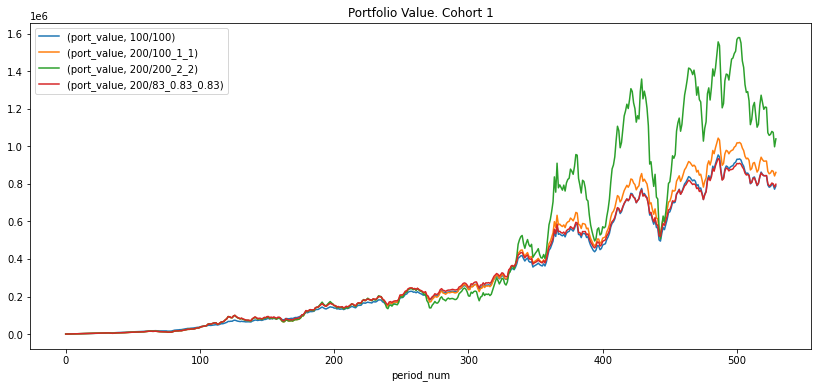

In [24]:
strategies = ['100/100', '200/83_0.83_0.83', '200/100_1_1', '200/200_2_2']

for cohort_num in results.cohort_num.unique()[0:1]:
    
    results2 = results.loc[((results.strategy.isin(strategies)) & 
                            (results.cohort_num==cohort_num)),
                           ['strategy', 'cohort_num','period_num', 'port_value', 'Monthly_real_stock_rate', 'perc_targ']]

    results3 = pd.pivot(results2, 
                        index=['period_num'], 
                        columns=['strategy'], 
                        values=['port_value'])#, 'Monthly_real_stock_rate', 'perc_targ'])

    plt.rcParams['figure.figsize'] = (14, 6)
    results3.plot()
    plt.title('Portfolio Value. Cohort ' + str(cohort_num))
    plt.legend()
    plt.show()

In [295]:
results3.head(3)

port_value             Monthly_real_stock_rate            \
strategy       100/100      200/83                 100/100    200/83   
period_num                                                             
0                  0.0         0.0                     NaN       NaN   
1           157.453664  157.453664               -0.011781 -0.011781   
2           311.197379  315.212525                 0.01423   0.01423   

           perc_targ         
strategy     100/100 200/83  
period_num                   
0                0.0    0.0  
1                1.0    2.0  
2                1.0    2.0

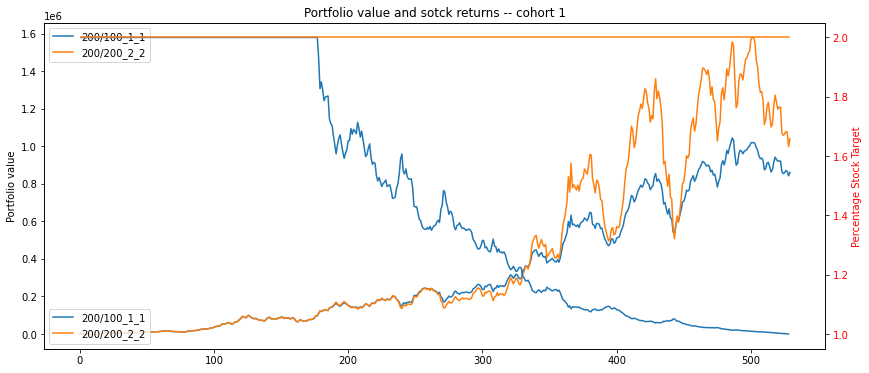

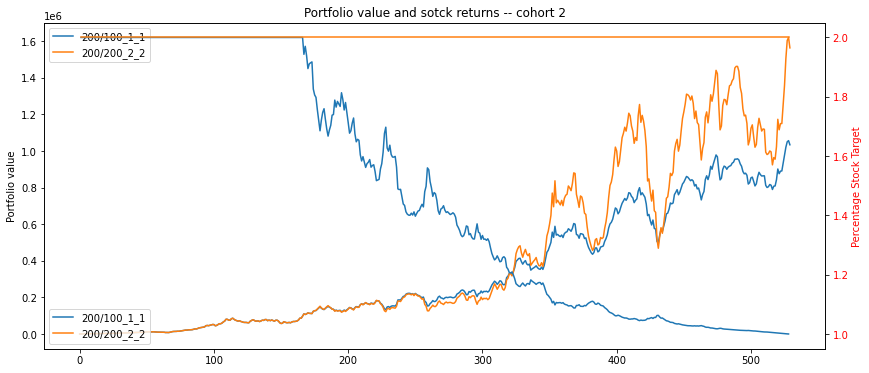

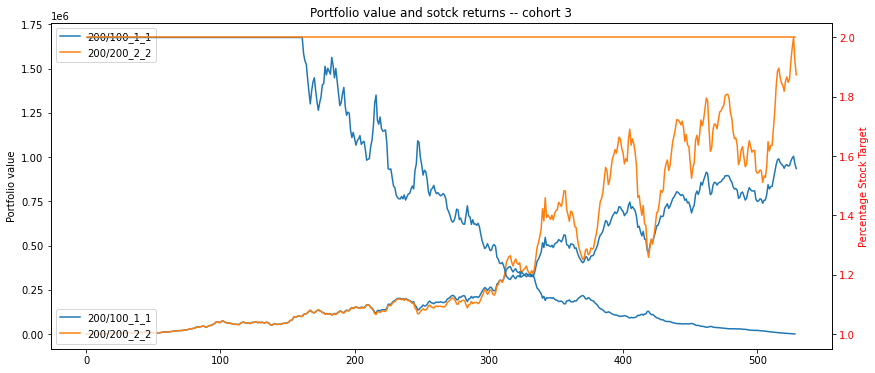

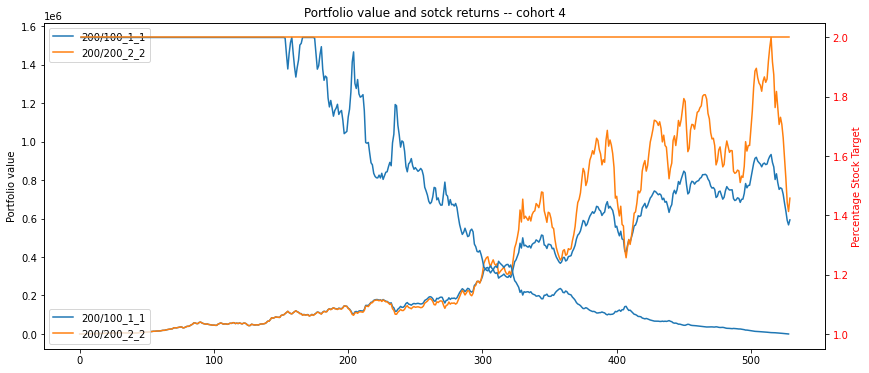

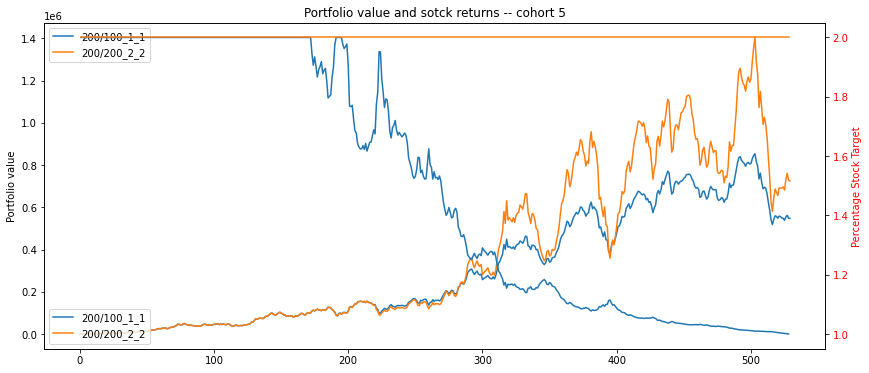

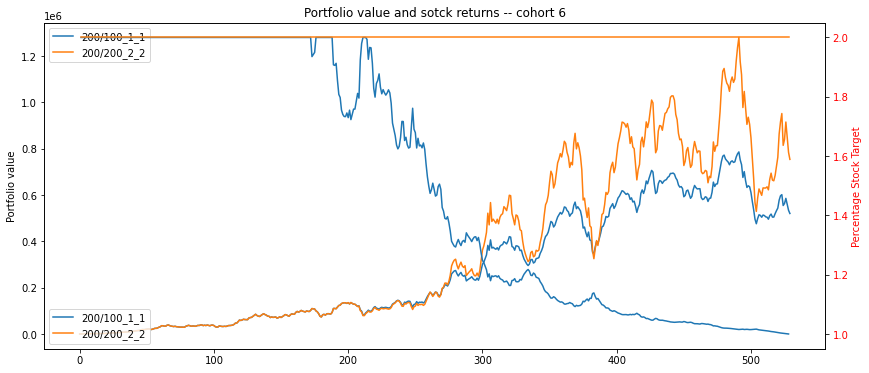

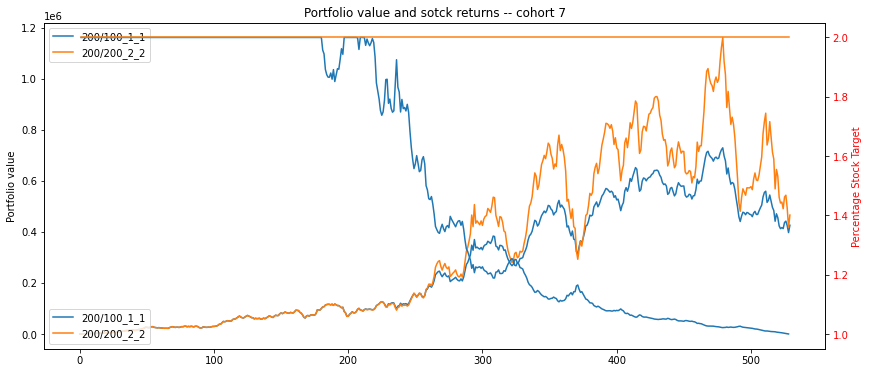

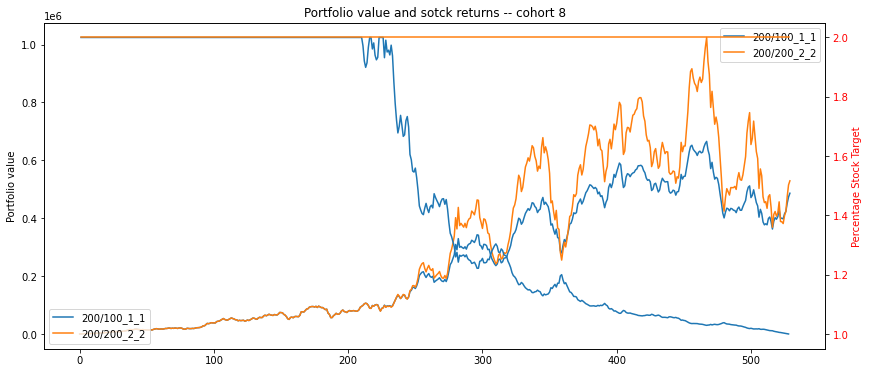

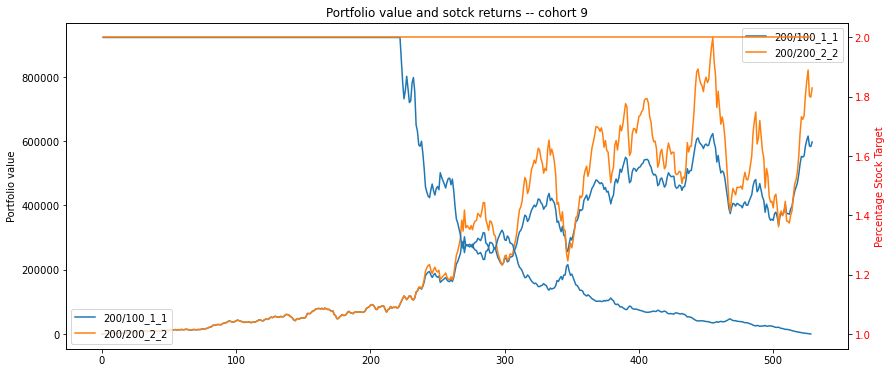

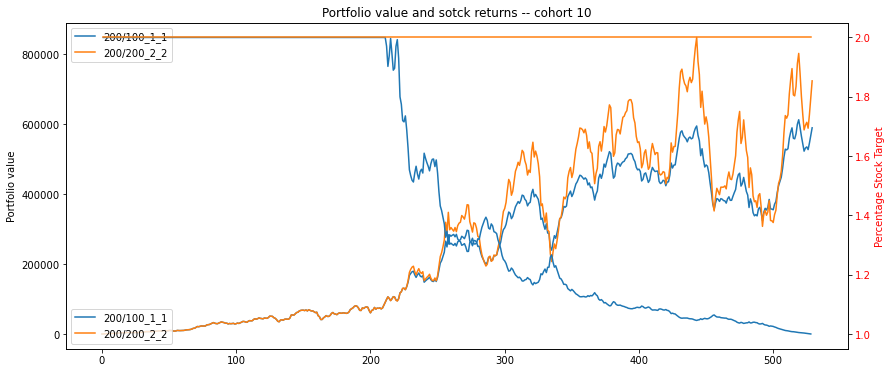

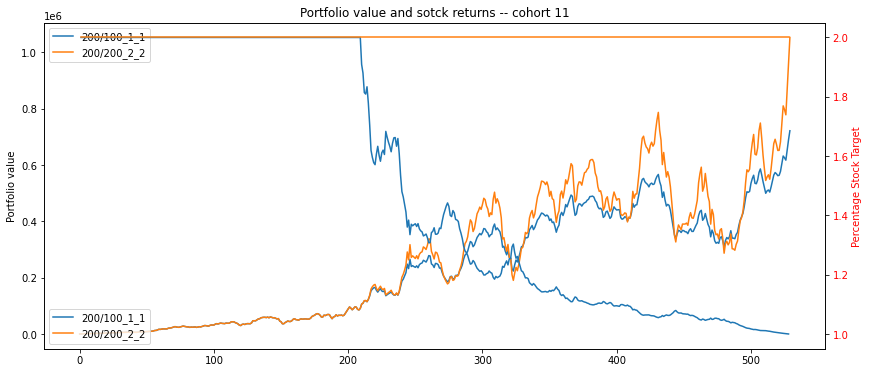

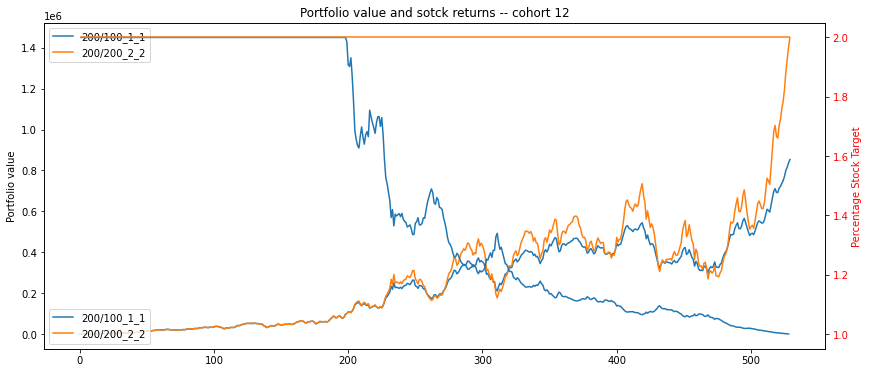

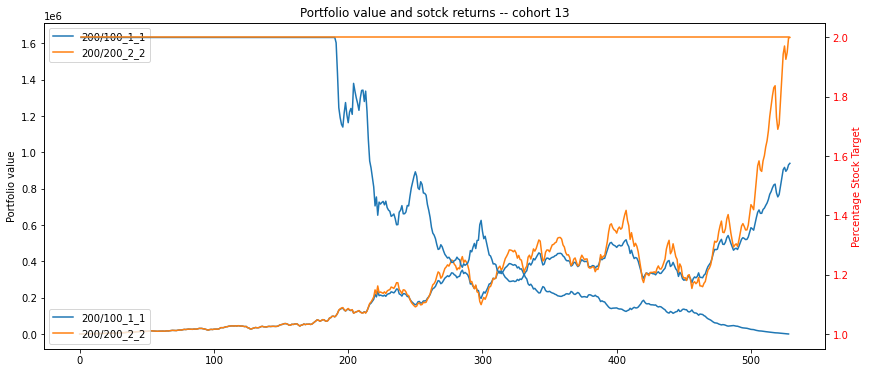

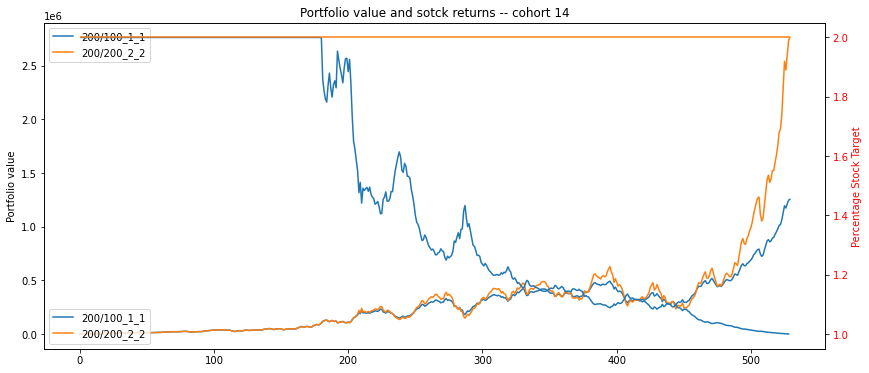

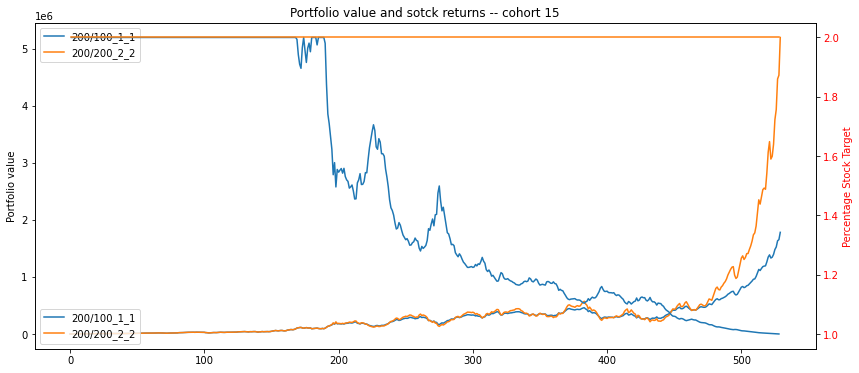

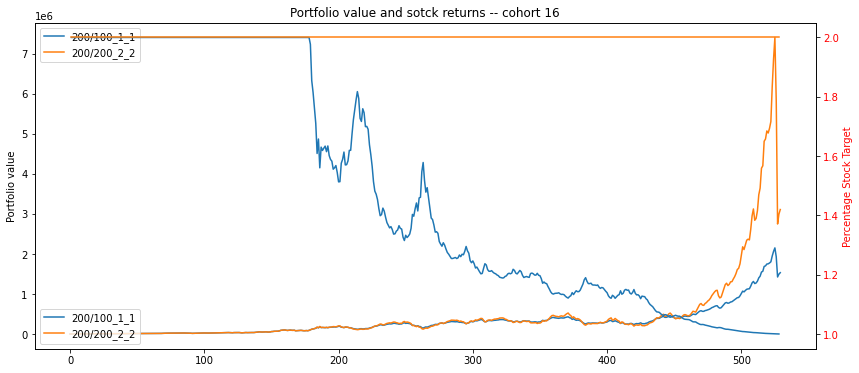

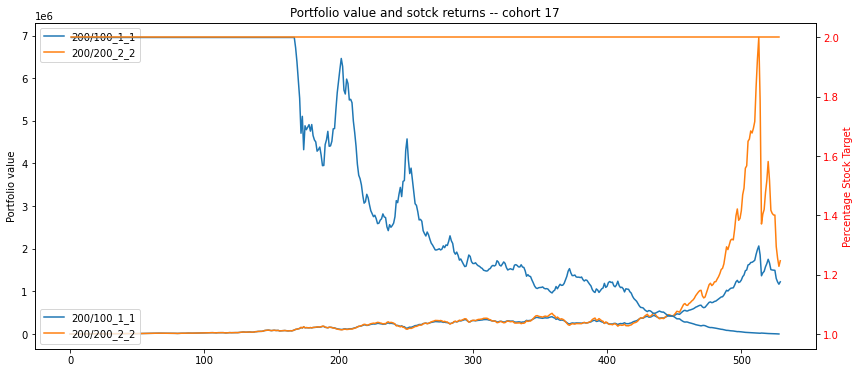

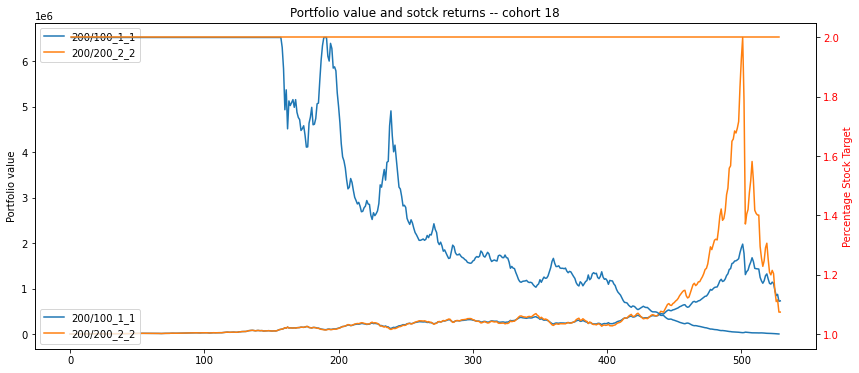

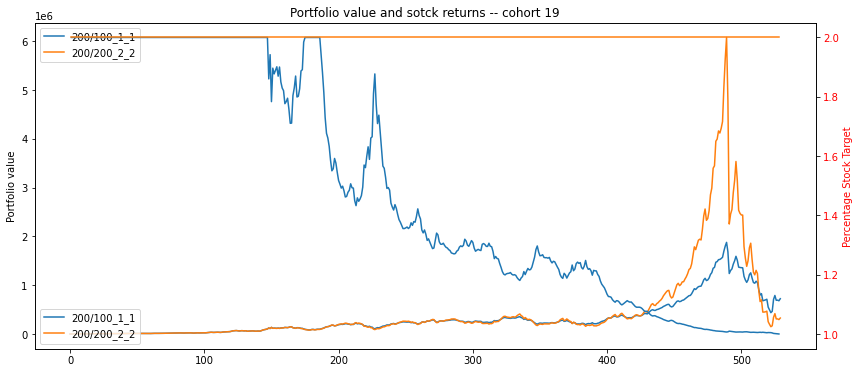

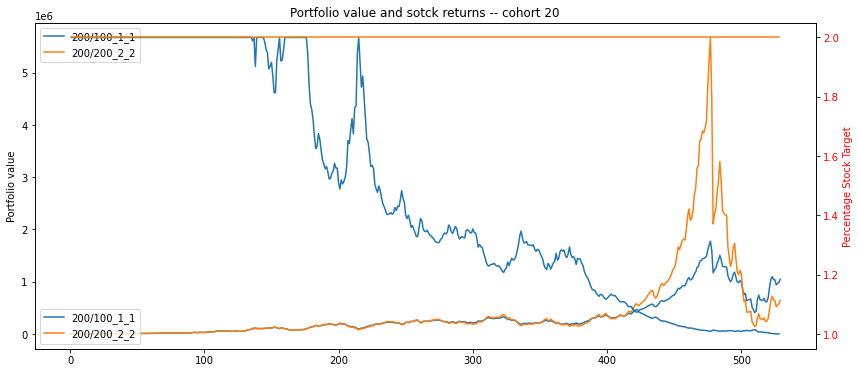

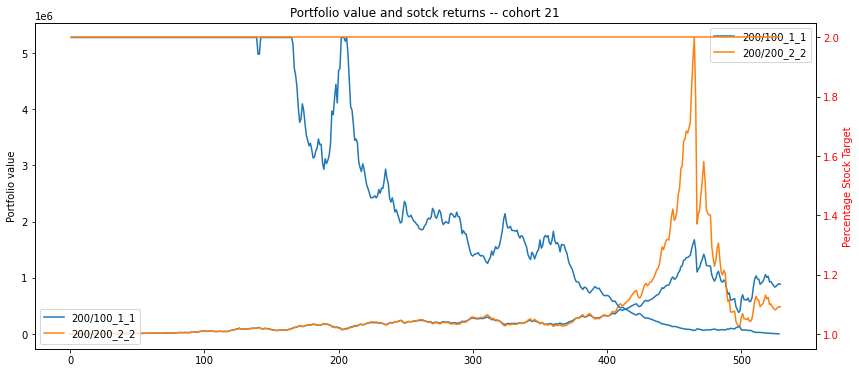

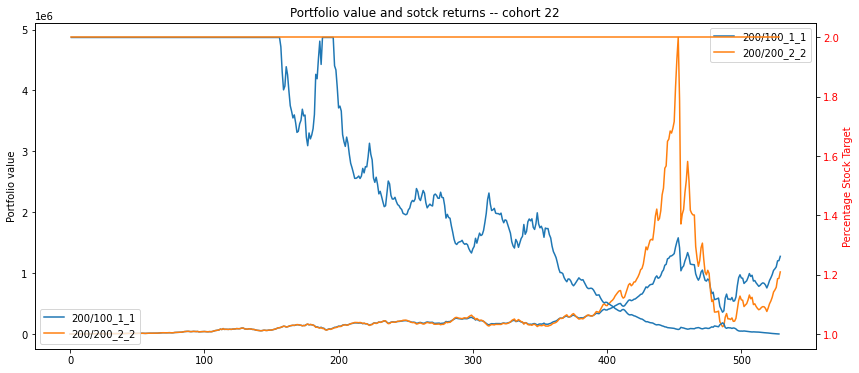

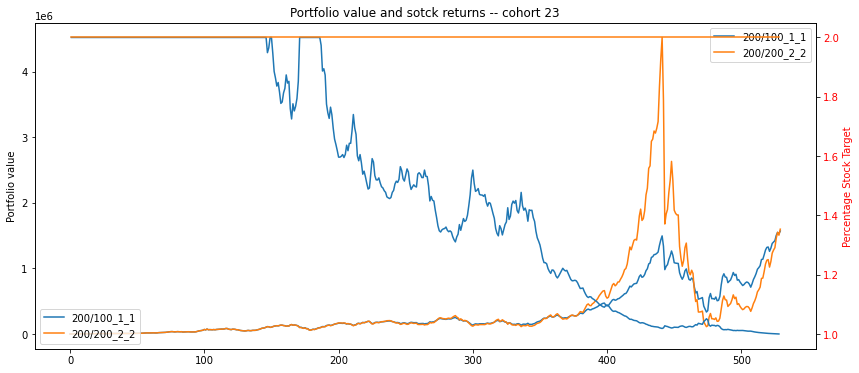

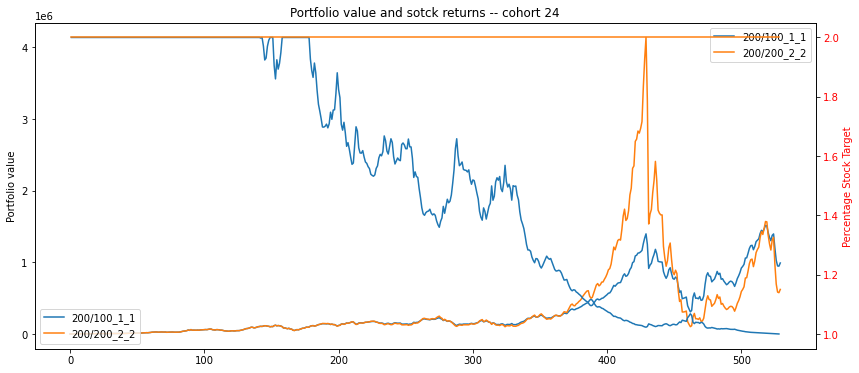

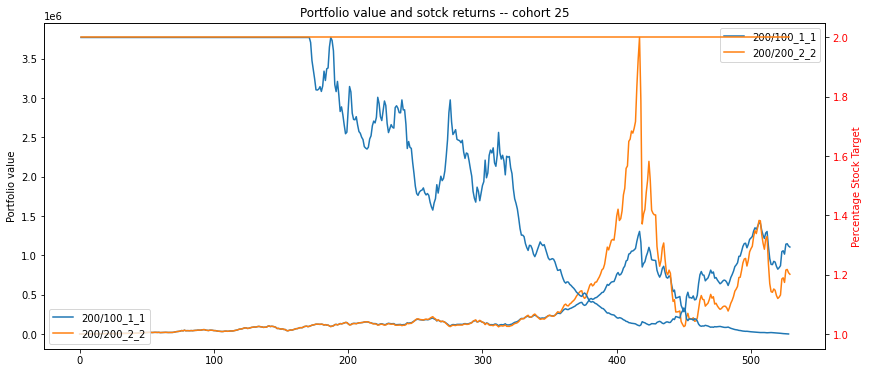

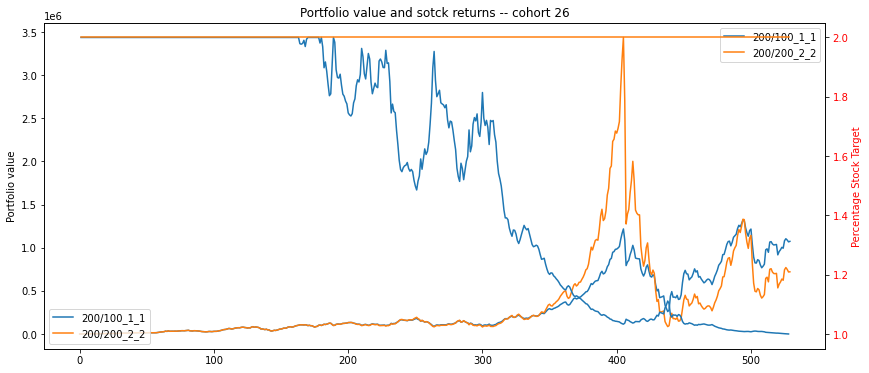

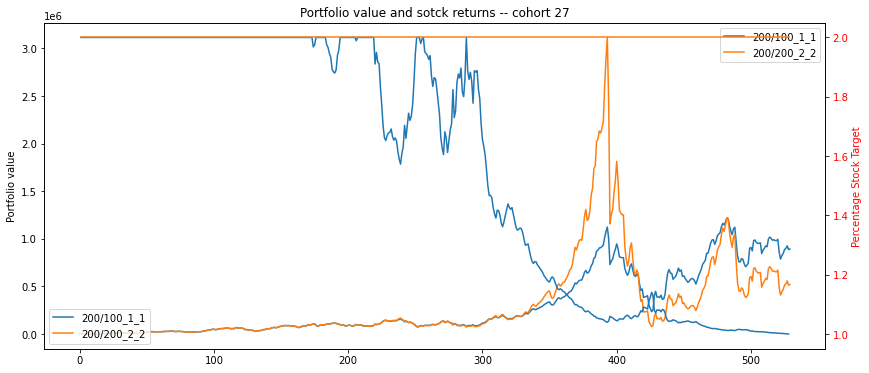

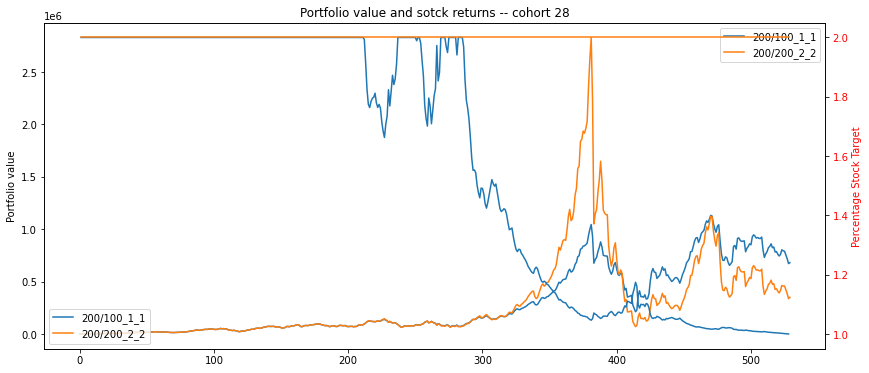

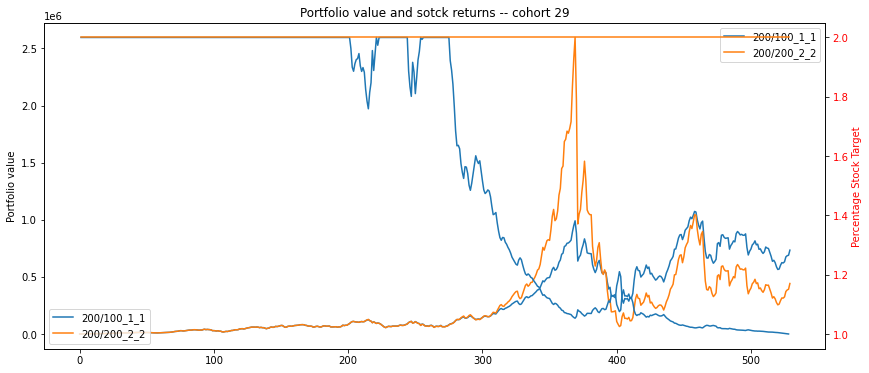

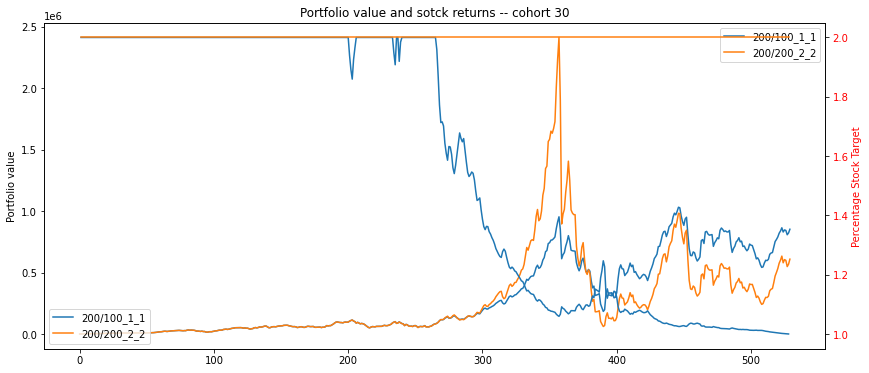

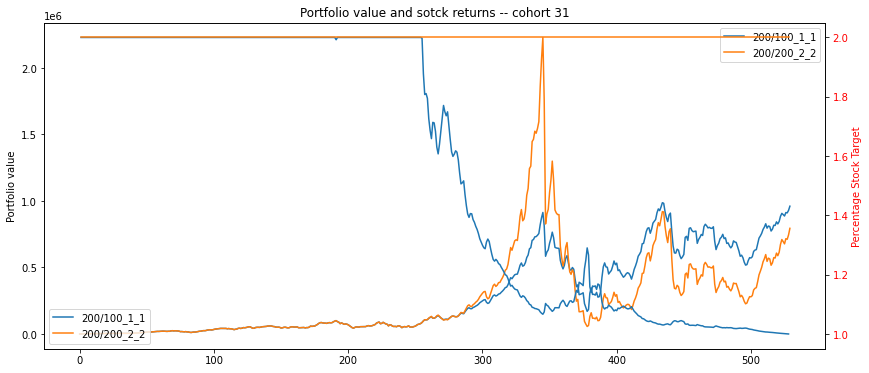

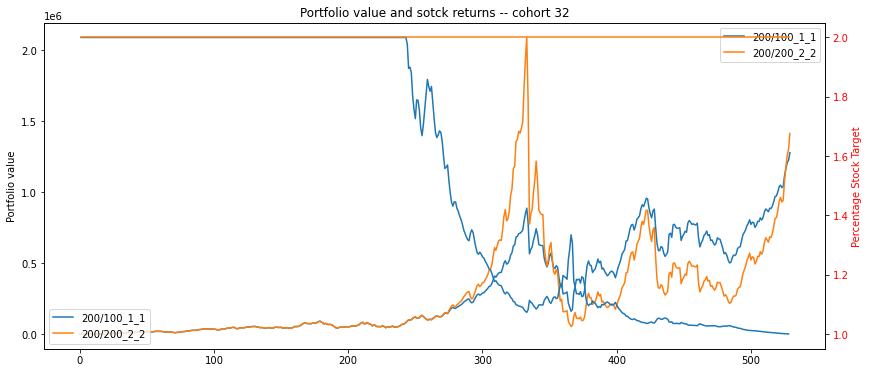

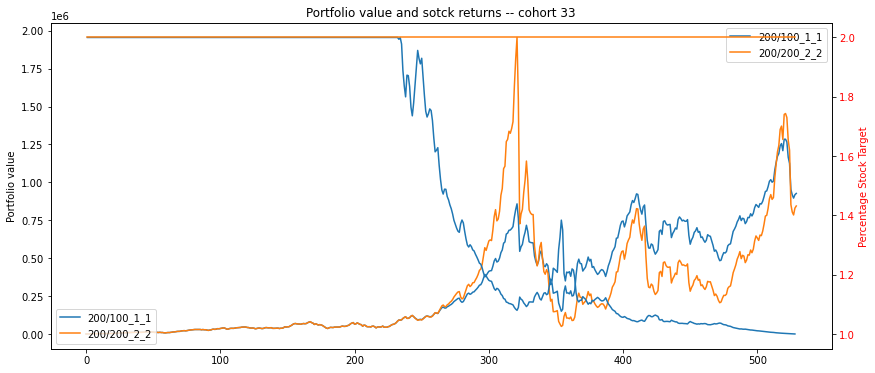

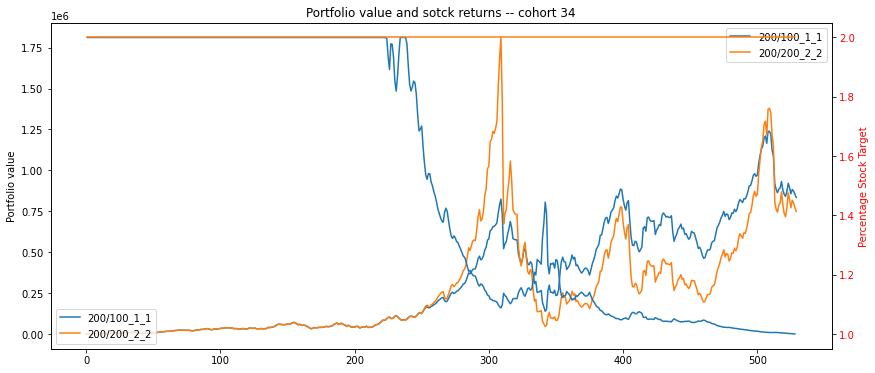

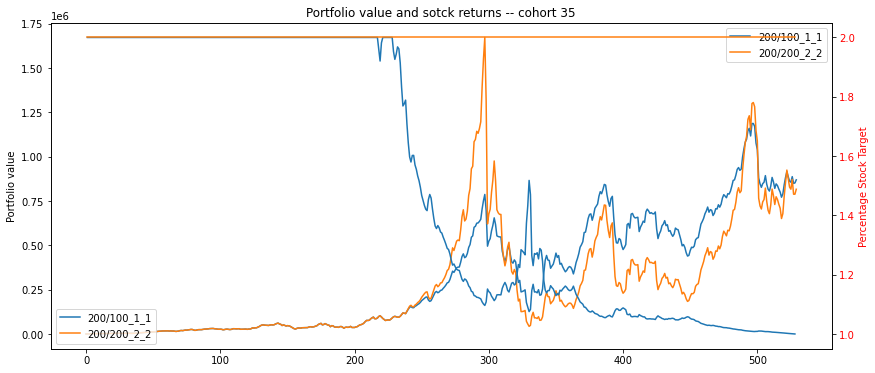

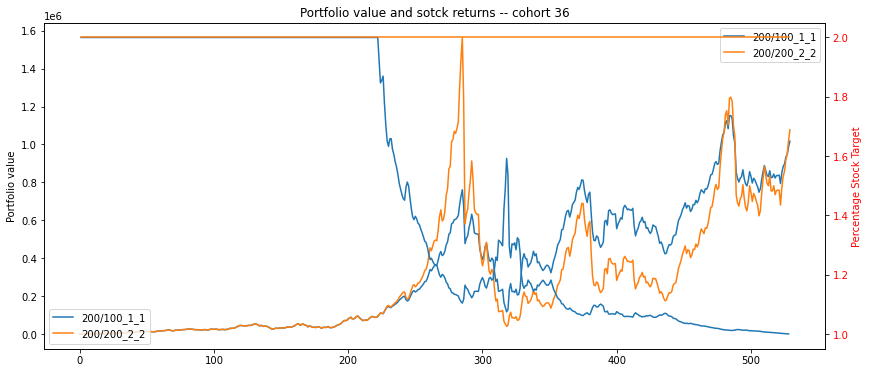

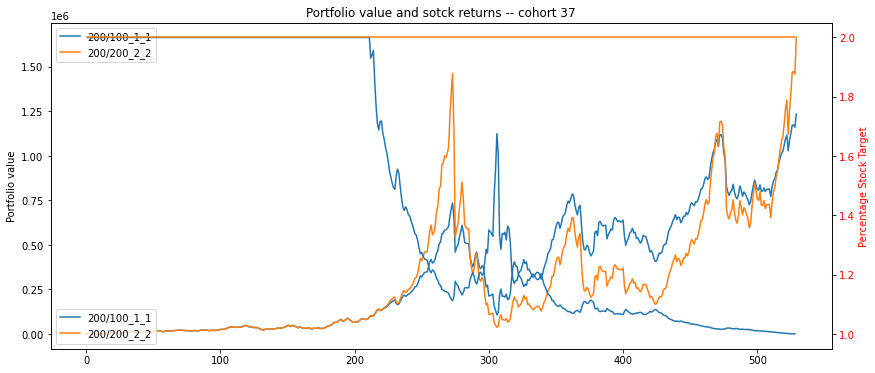

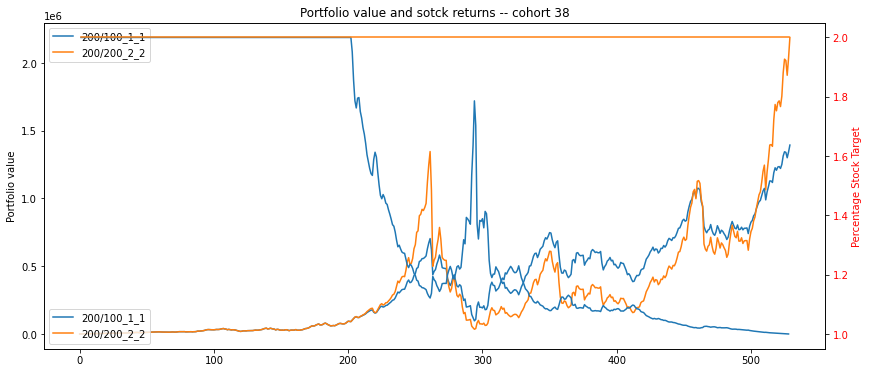

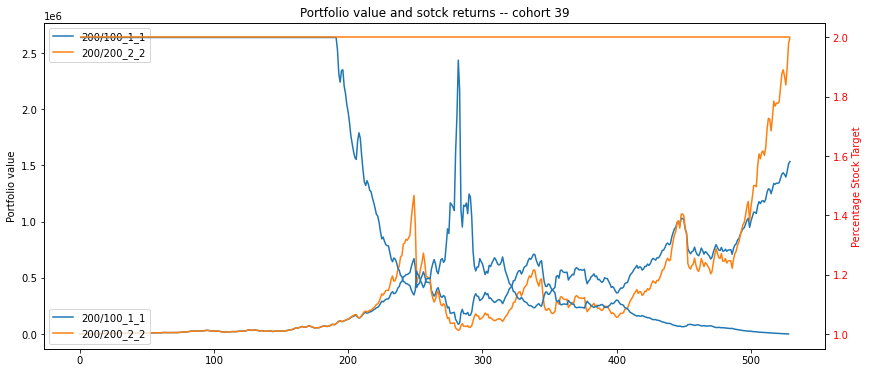

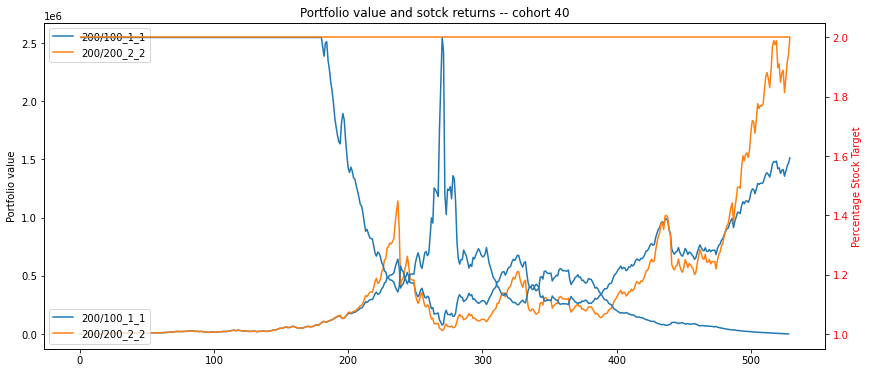

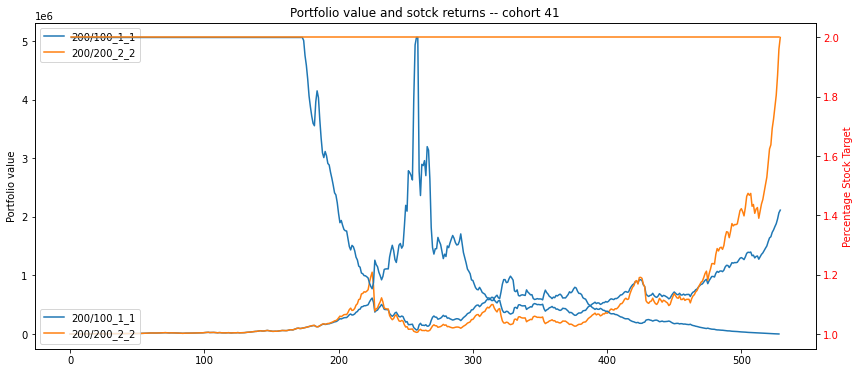

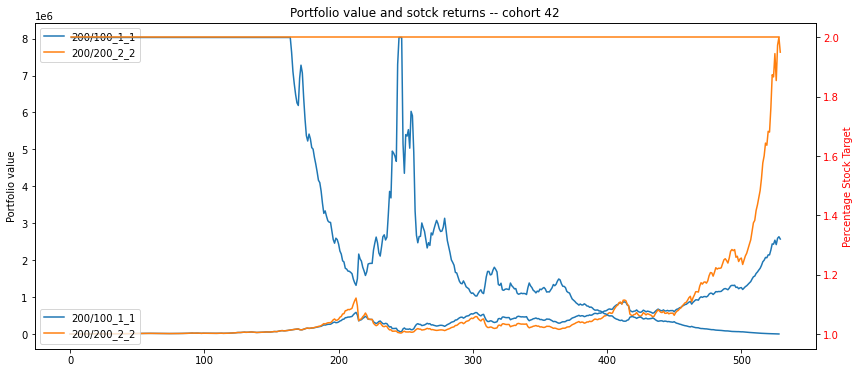

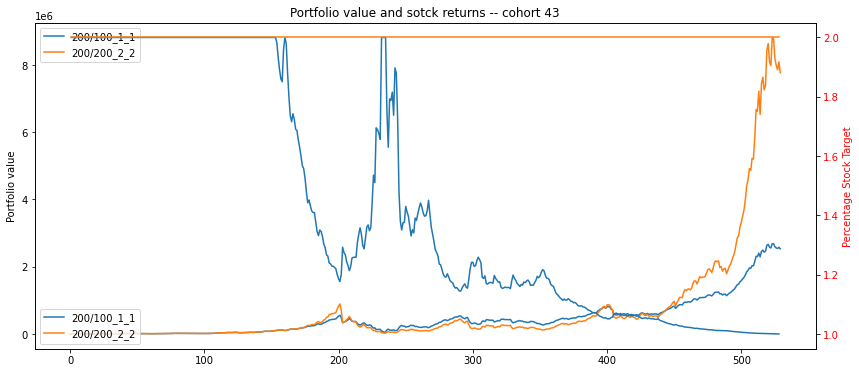

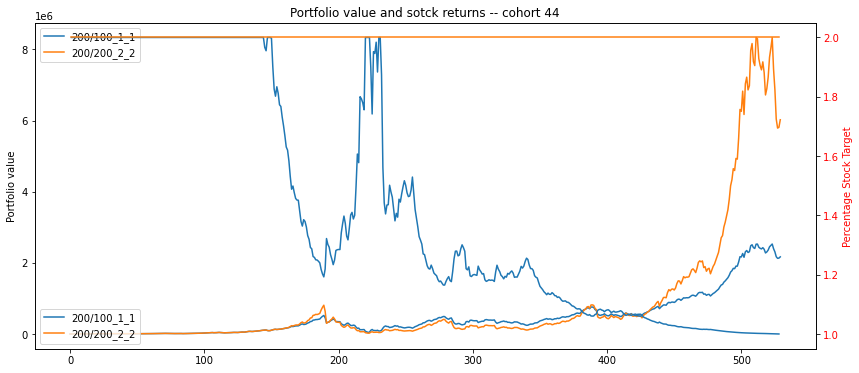

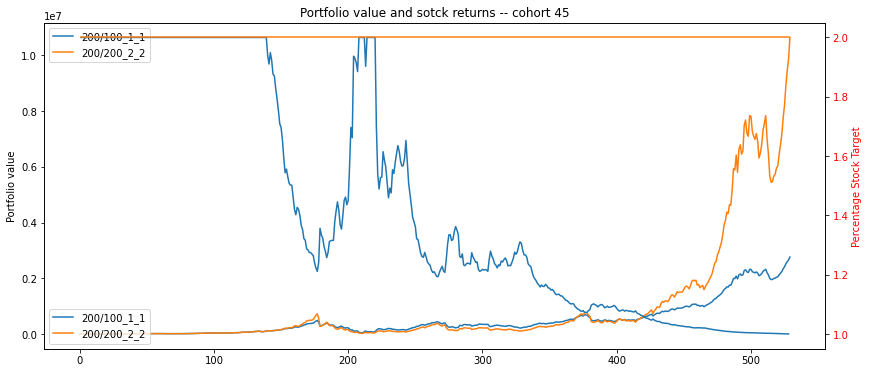

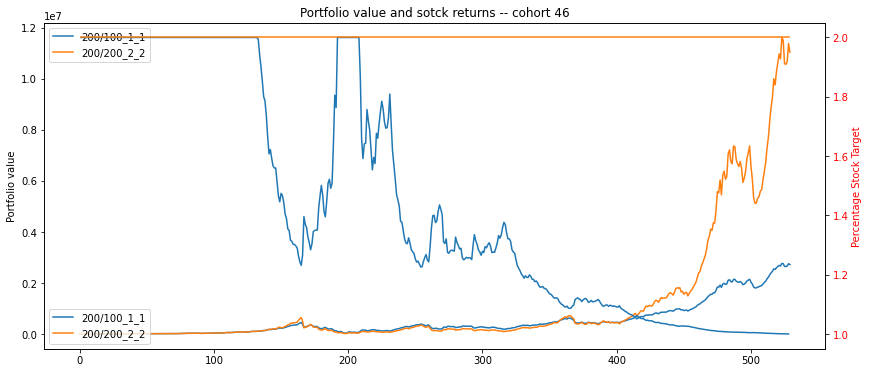

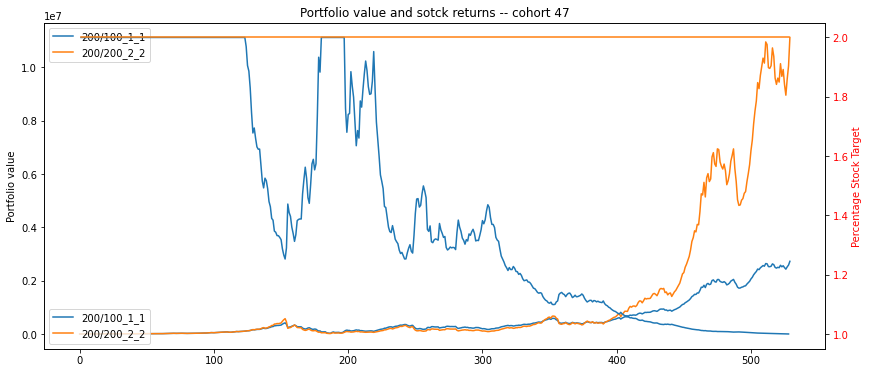

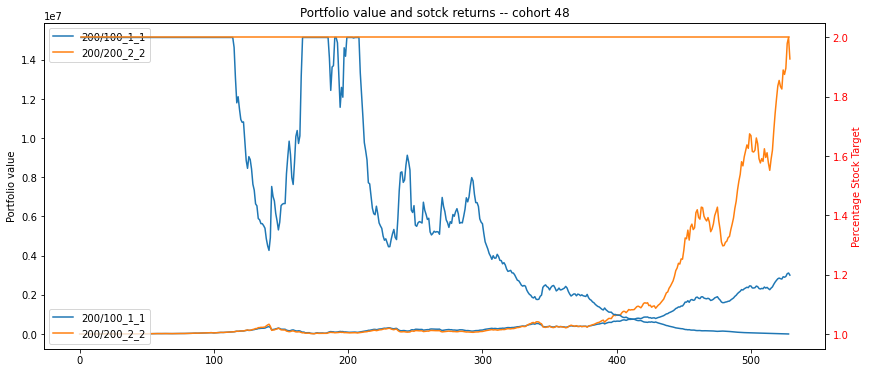

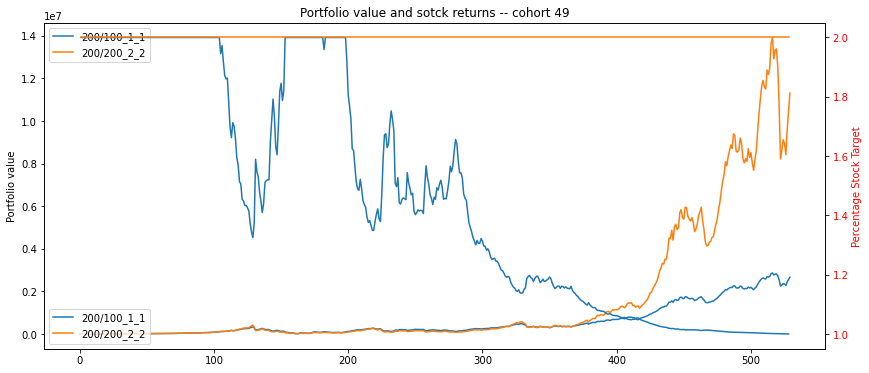

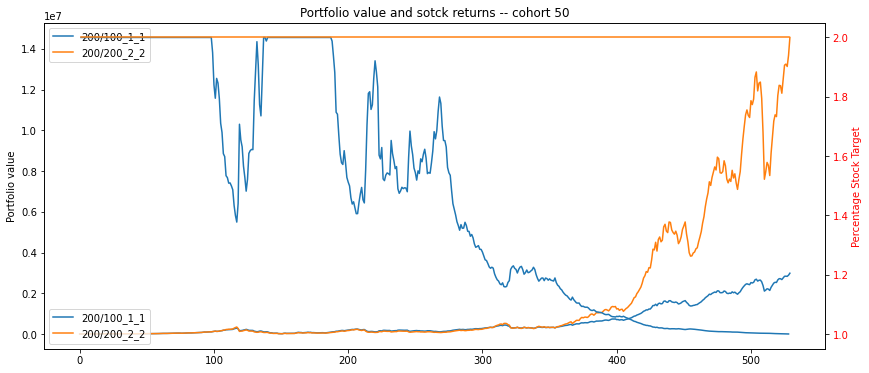

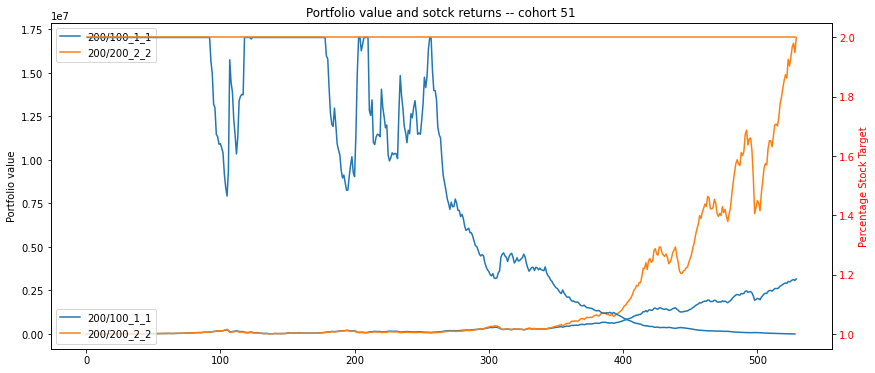

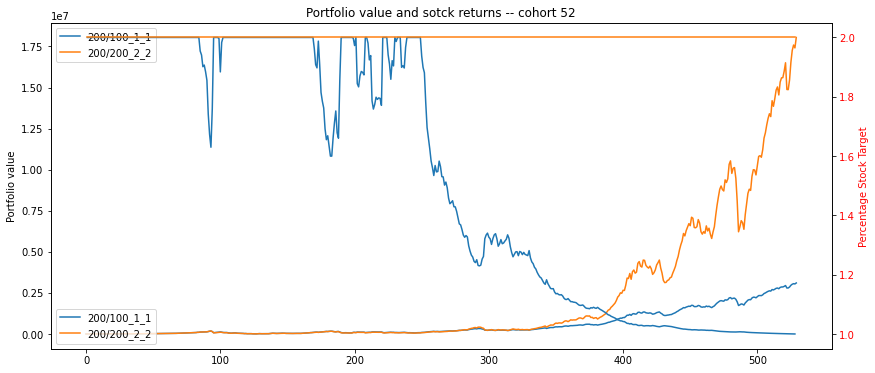

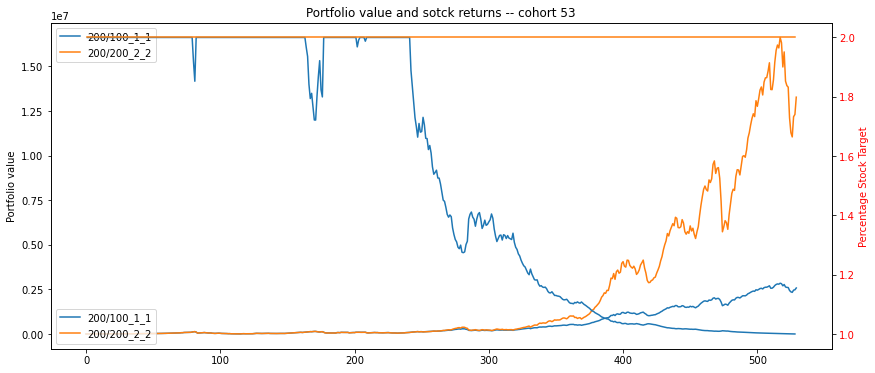

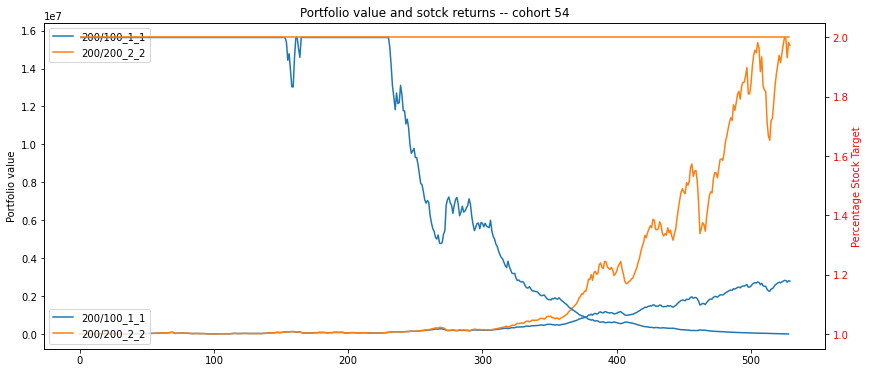

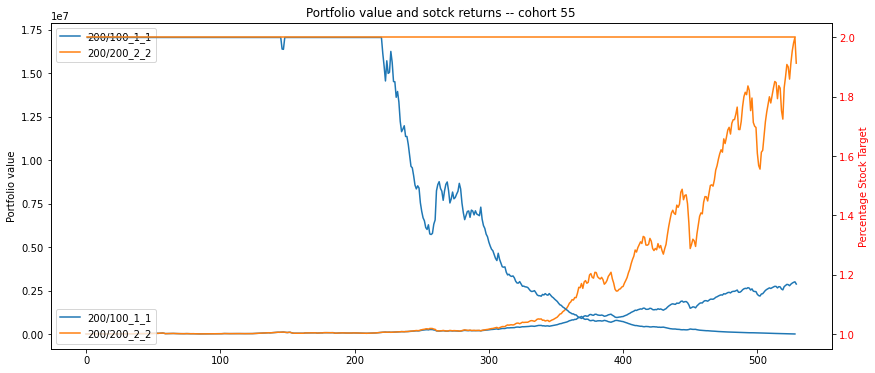

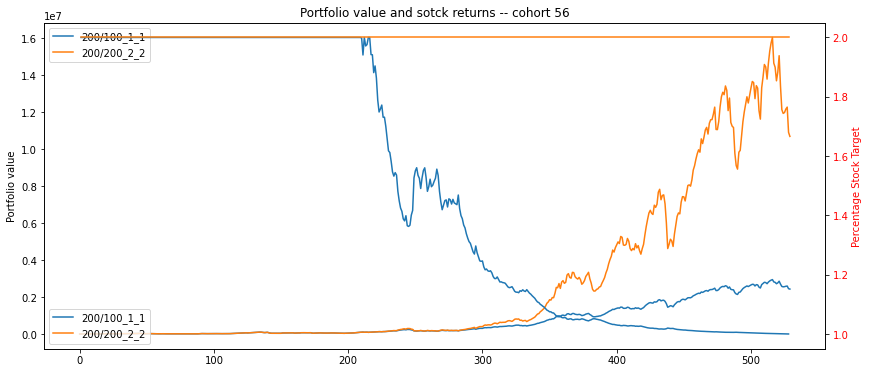

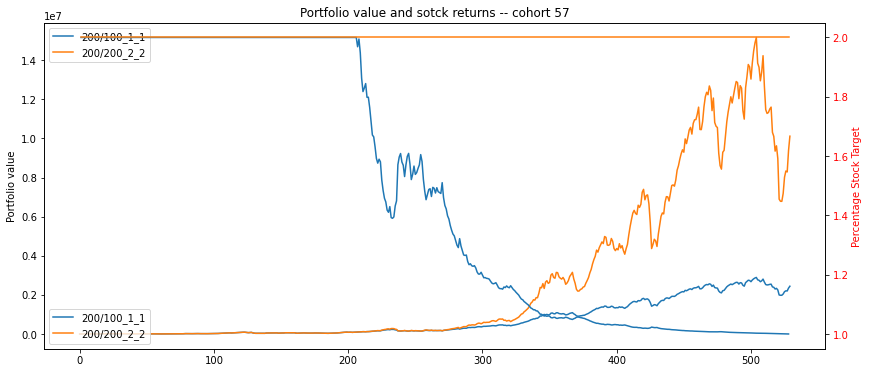

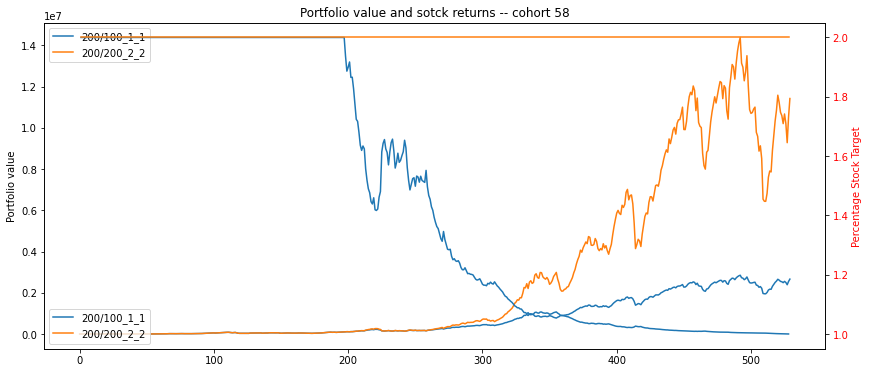

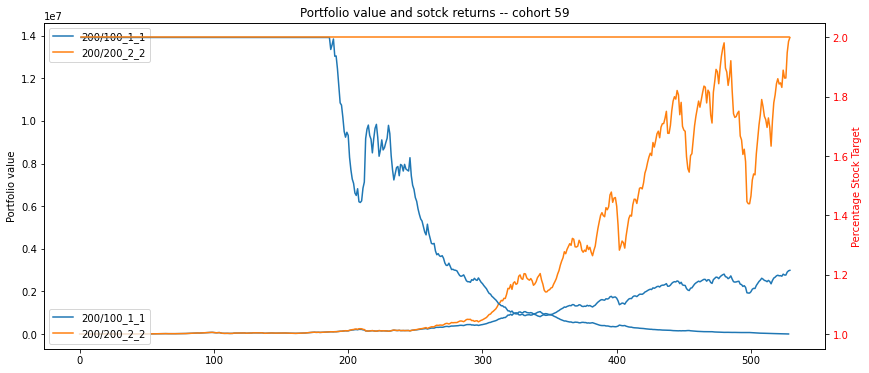

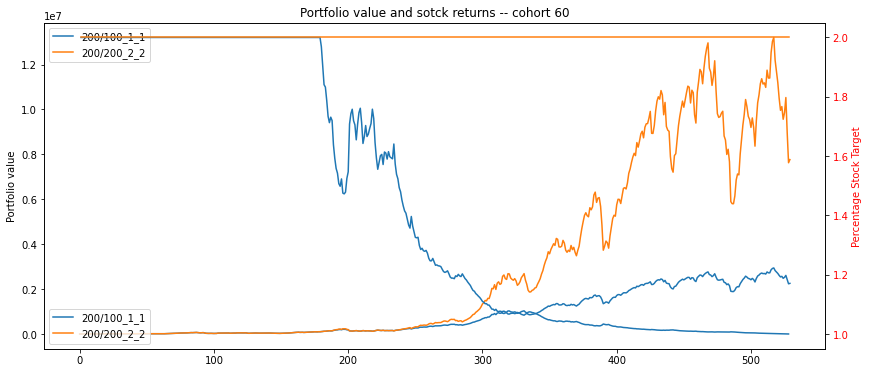

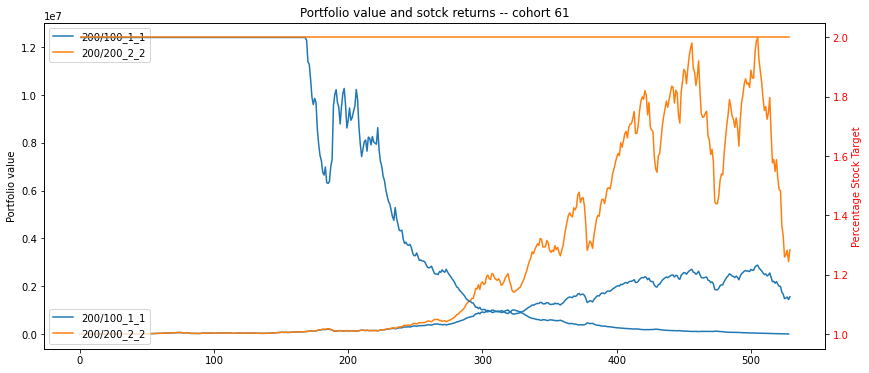

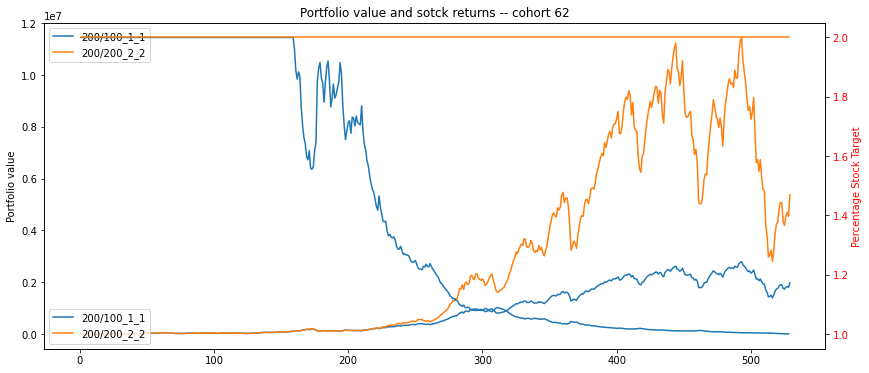

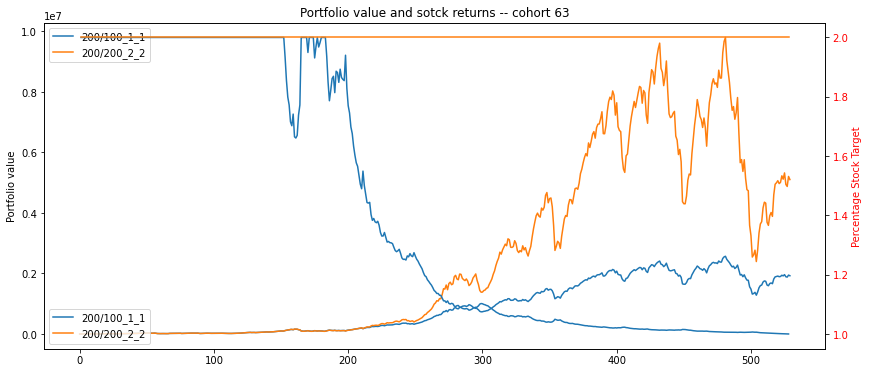

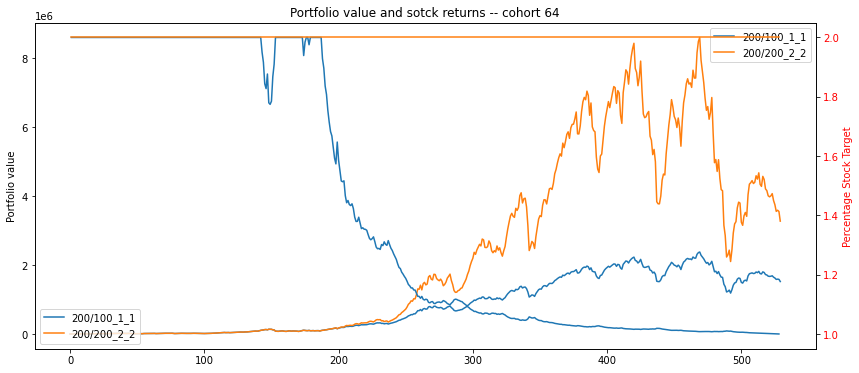

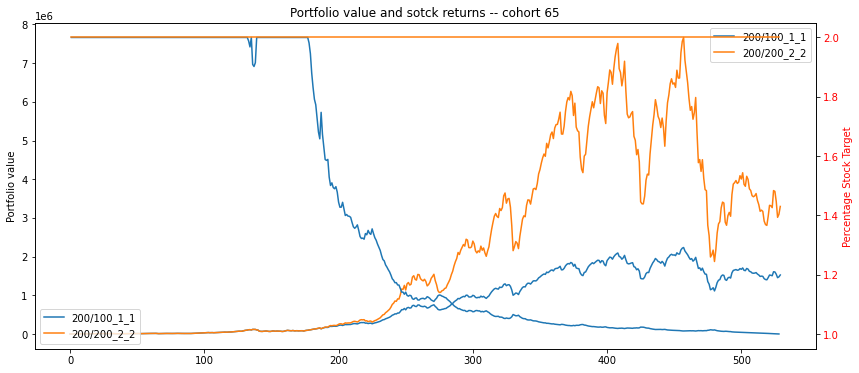

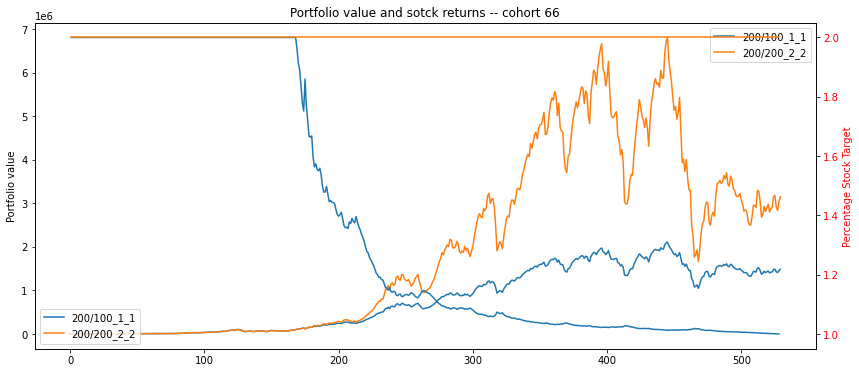

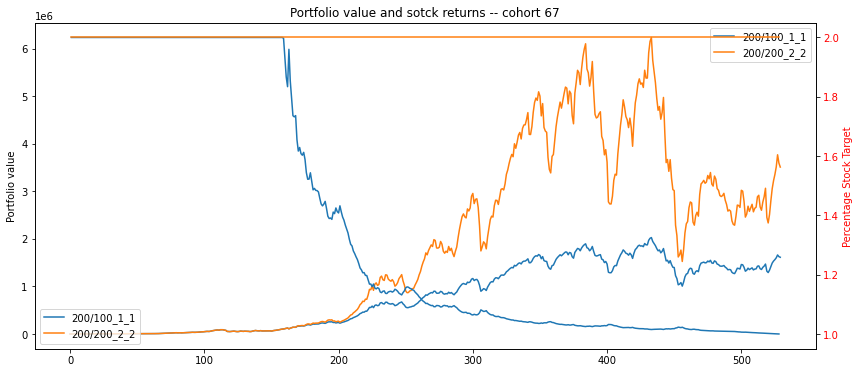

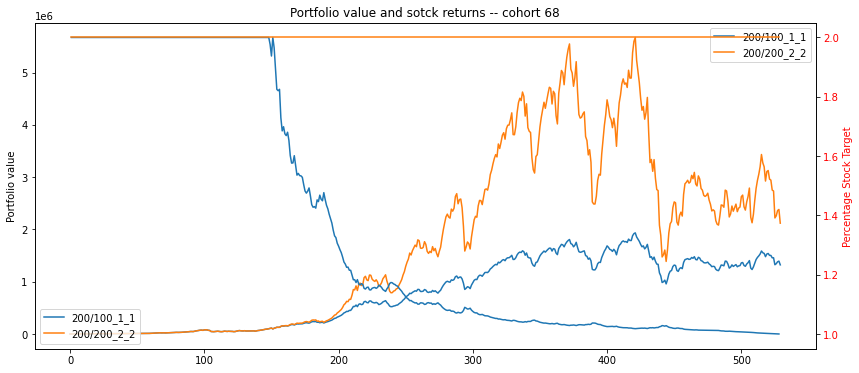

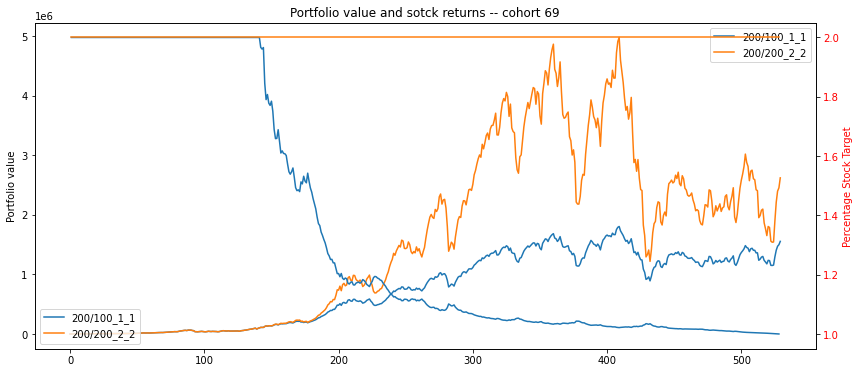

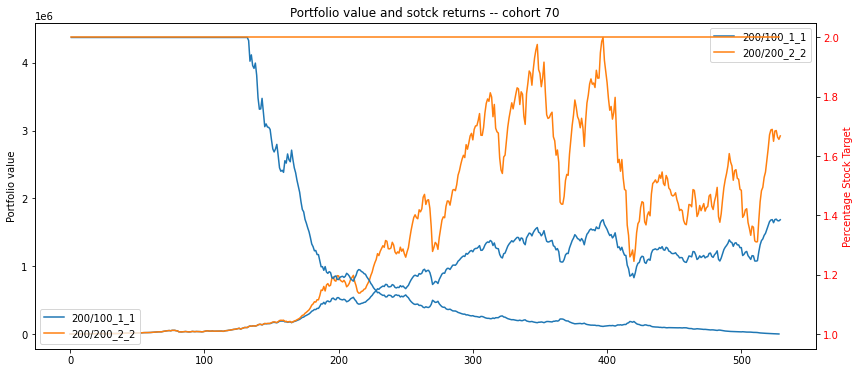

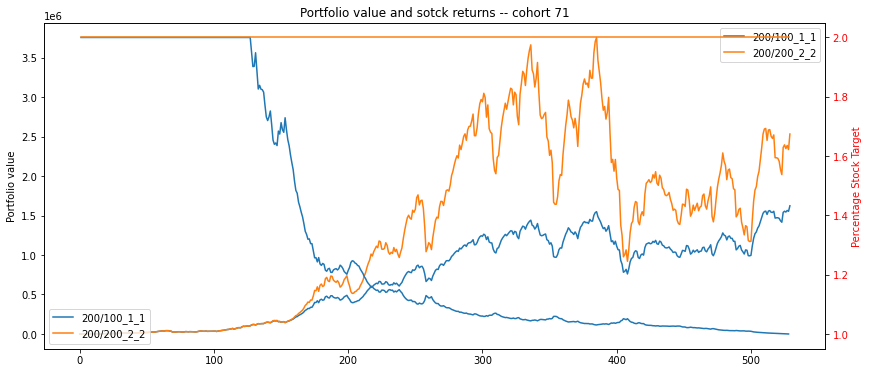

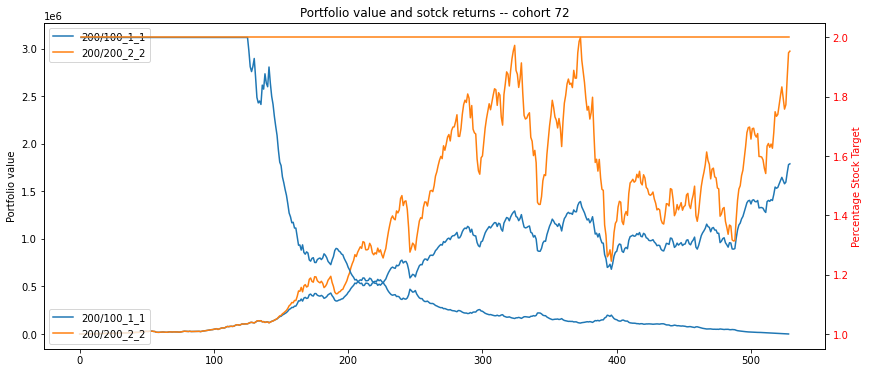

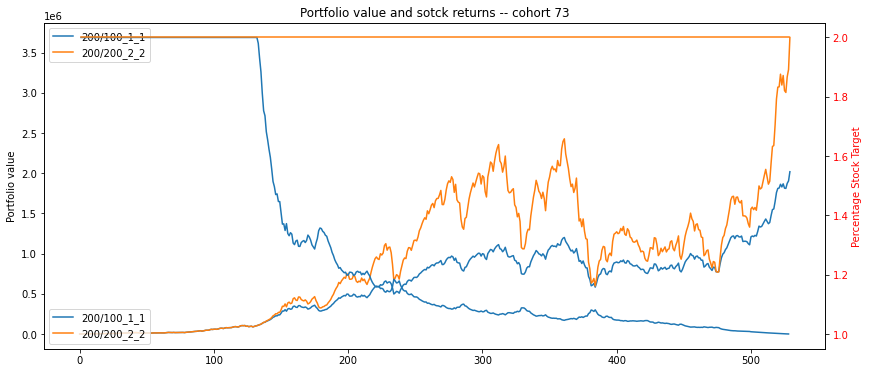

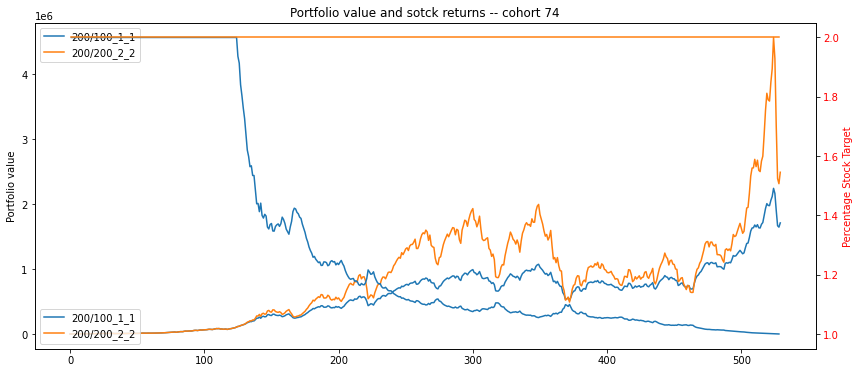

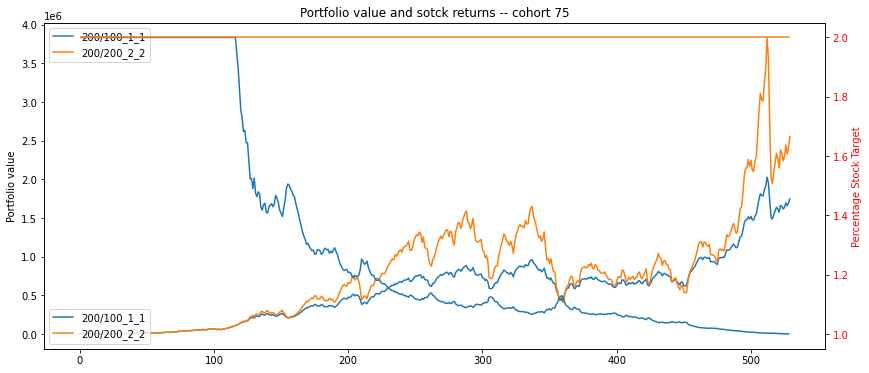

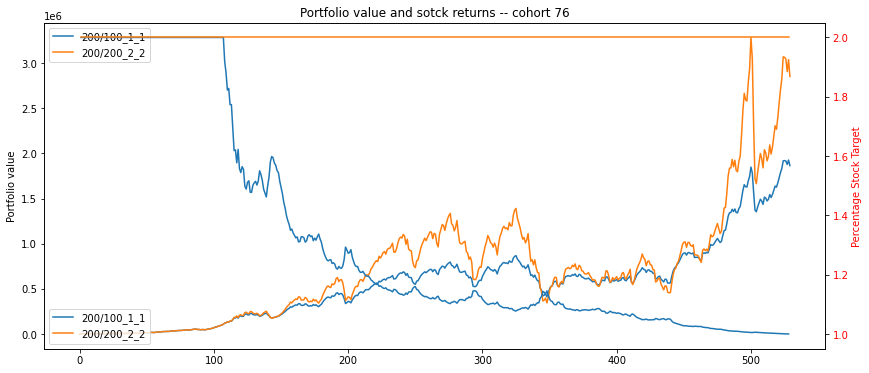

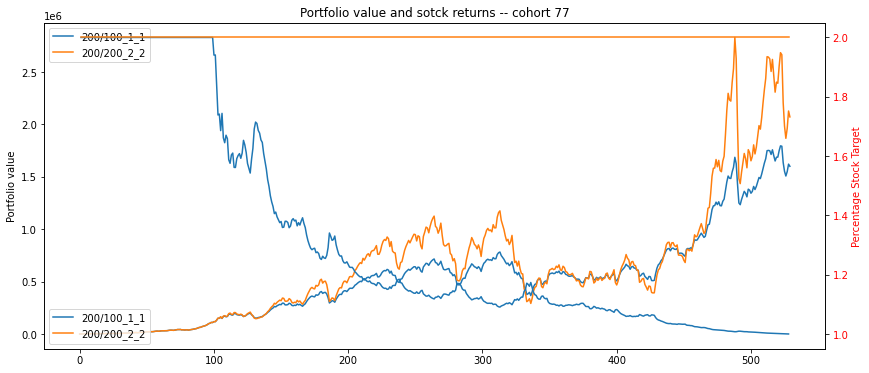

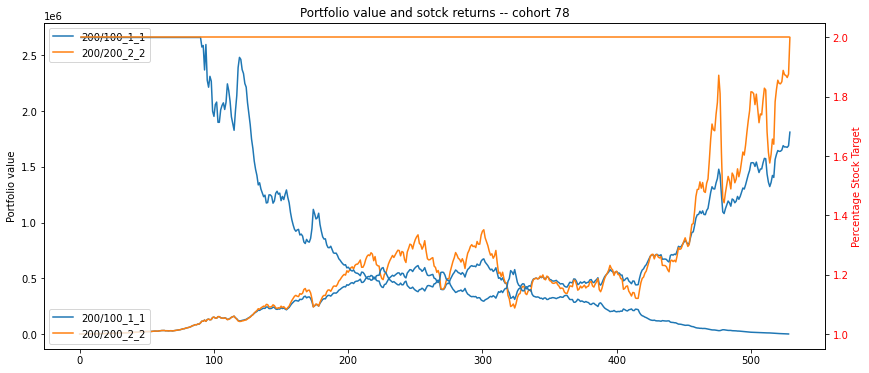

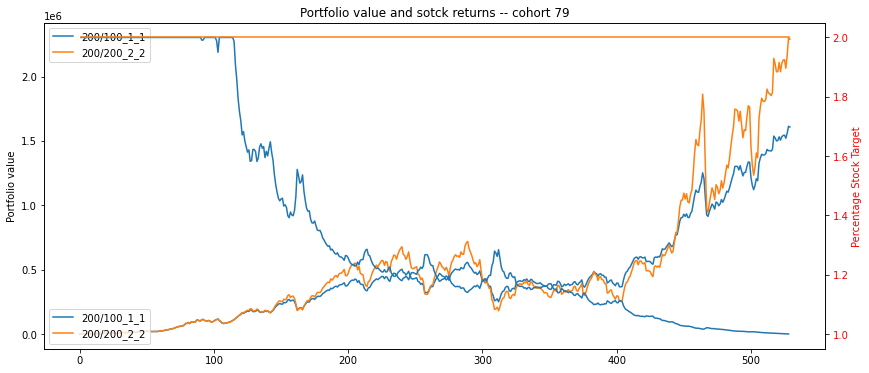

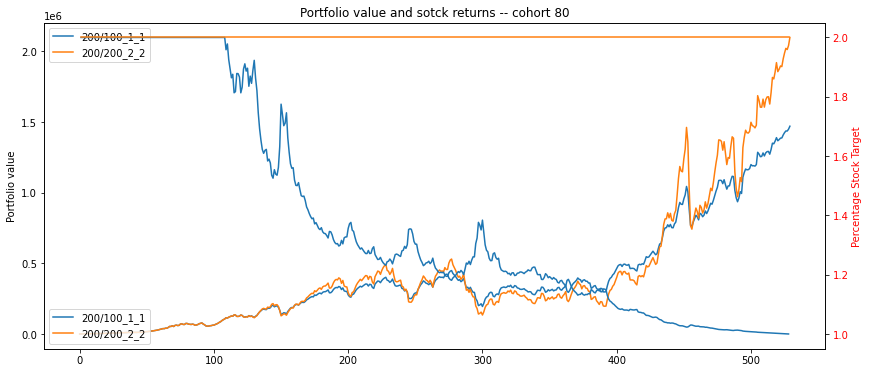

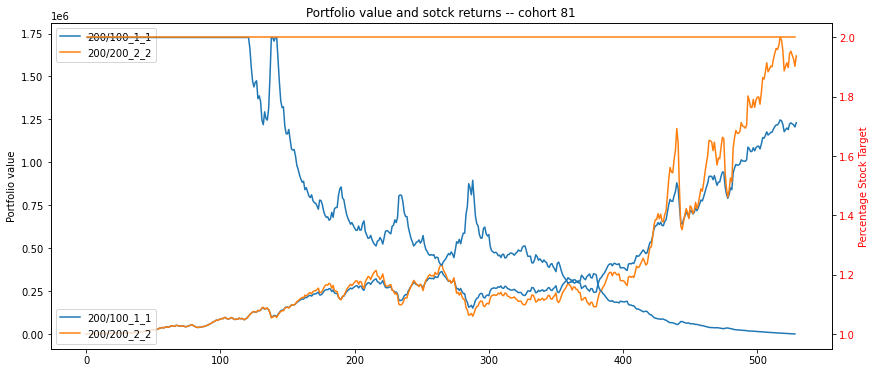

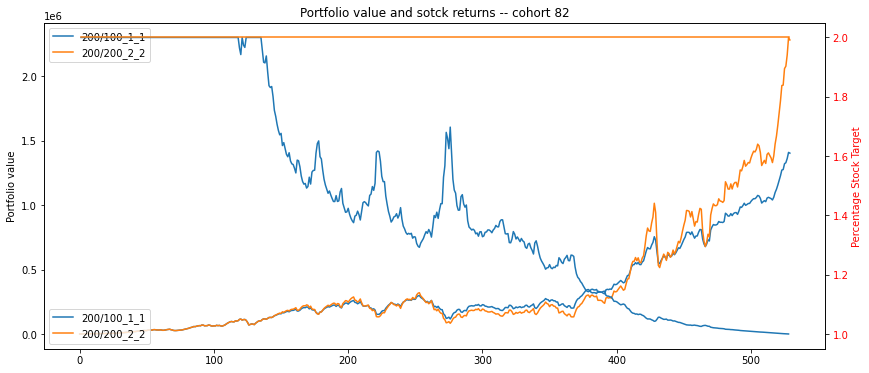

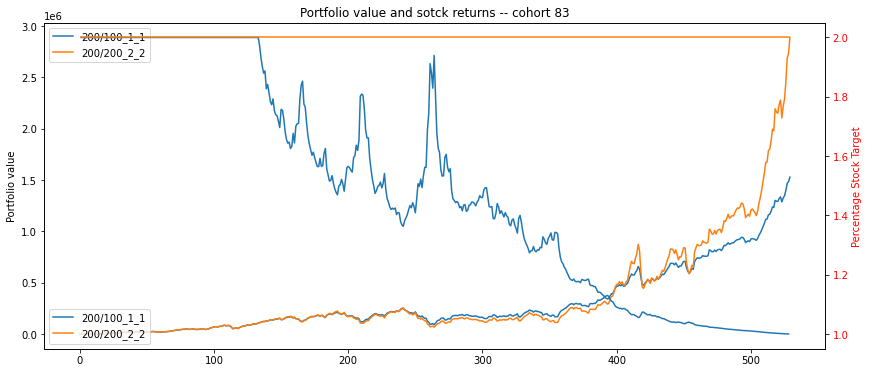

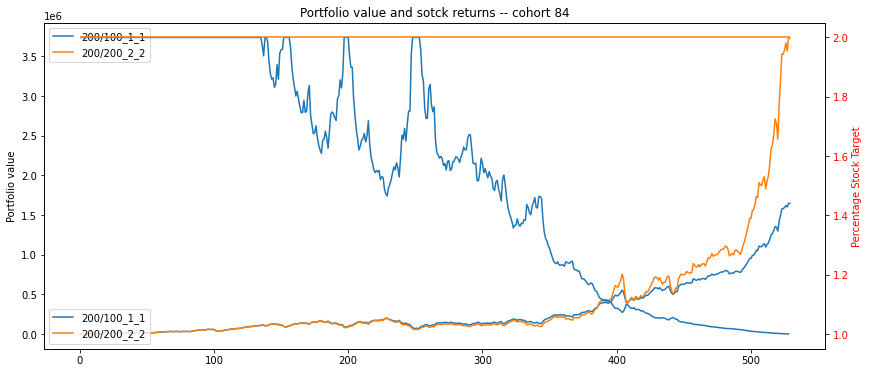

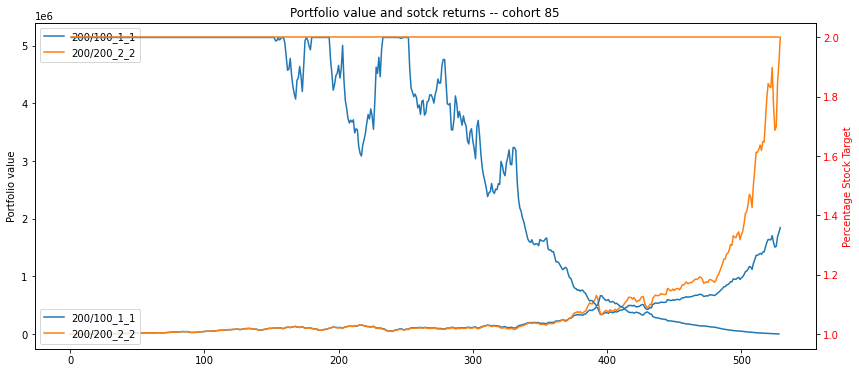

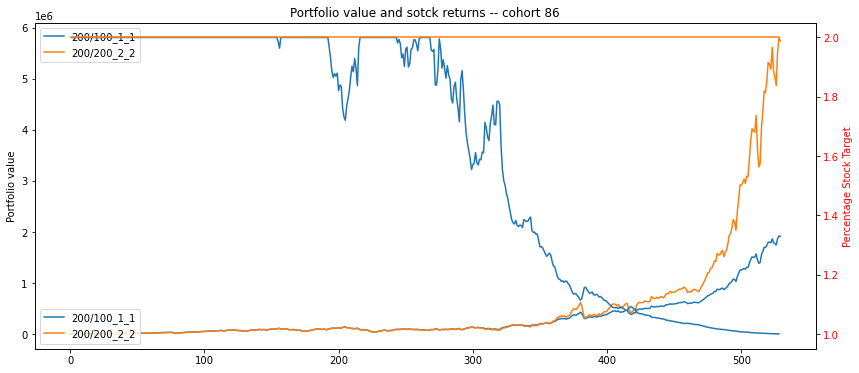

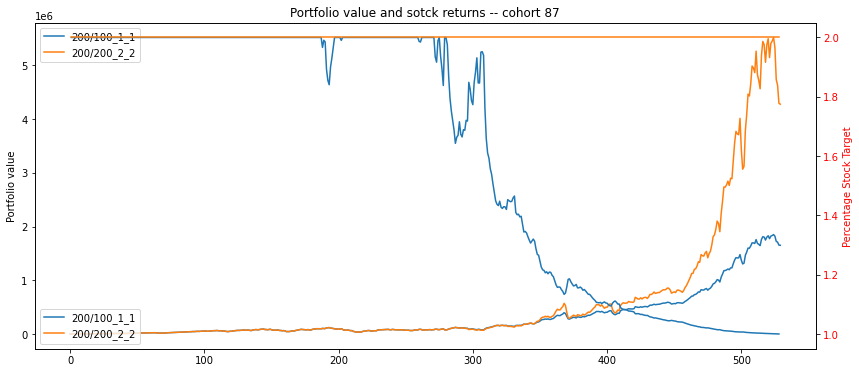

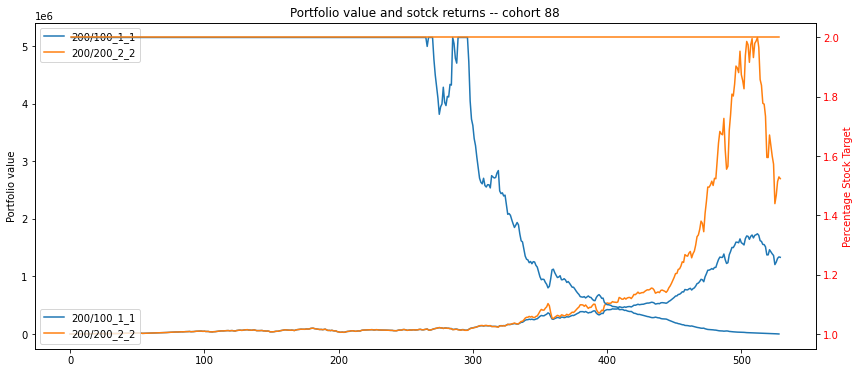

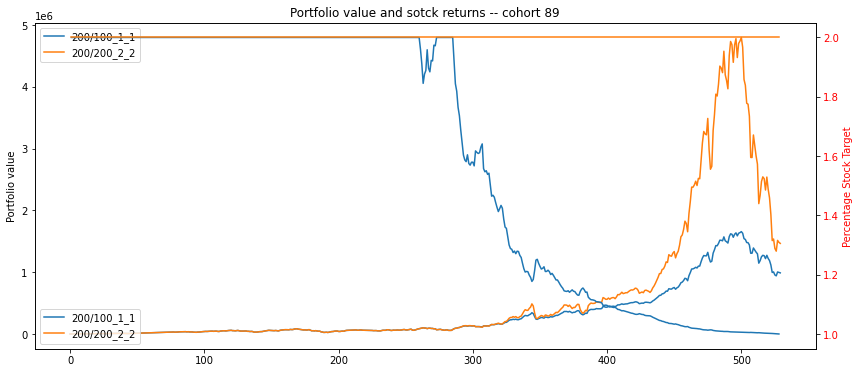

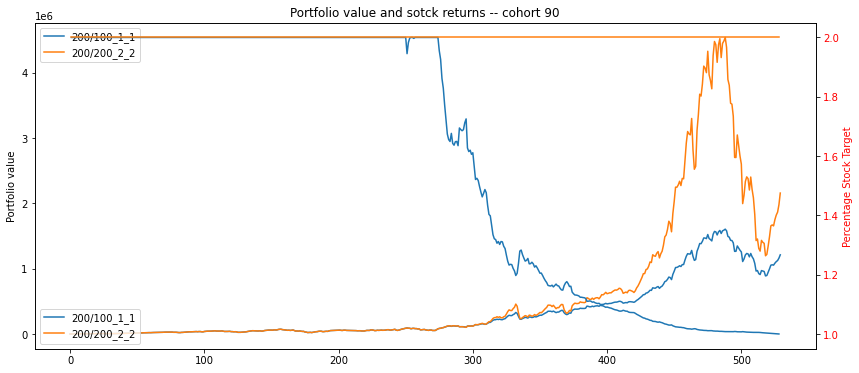

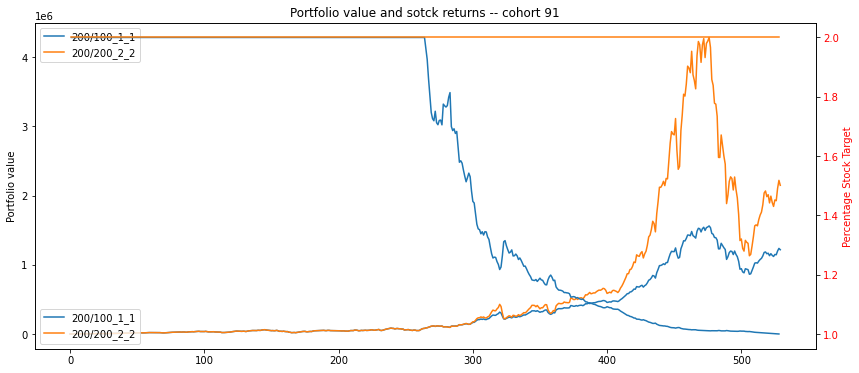

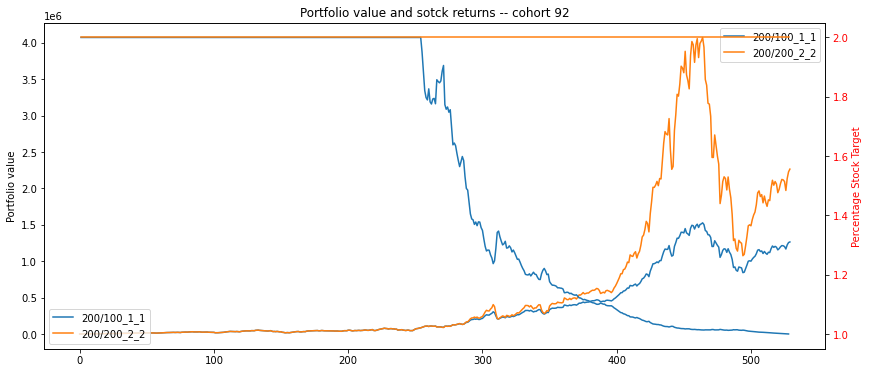

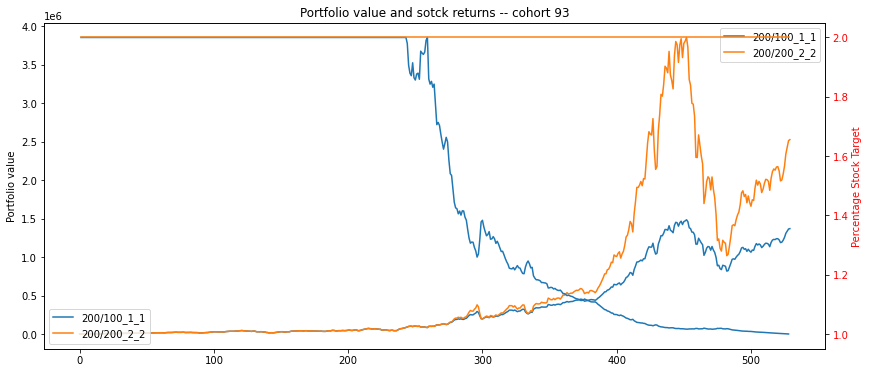

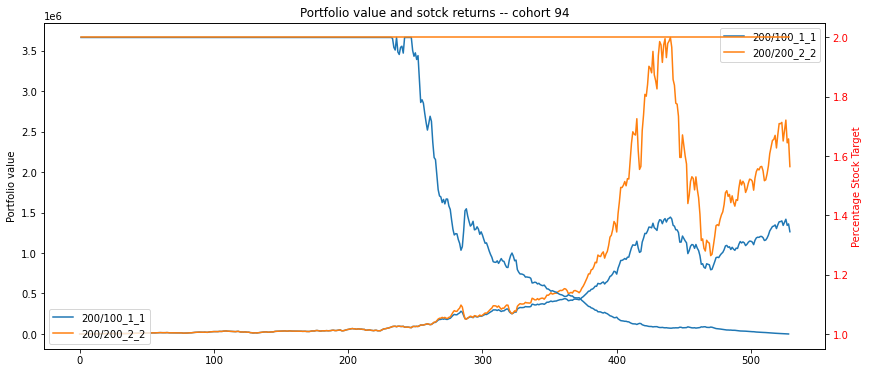

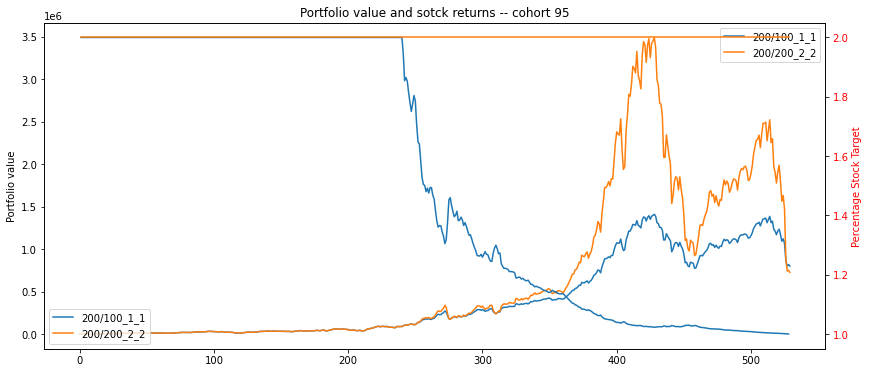

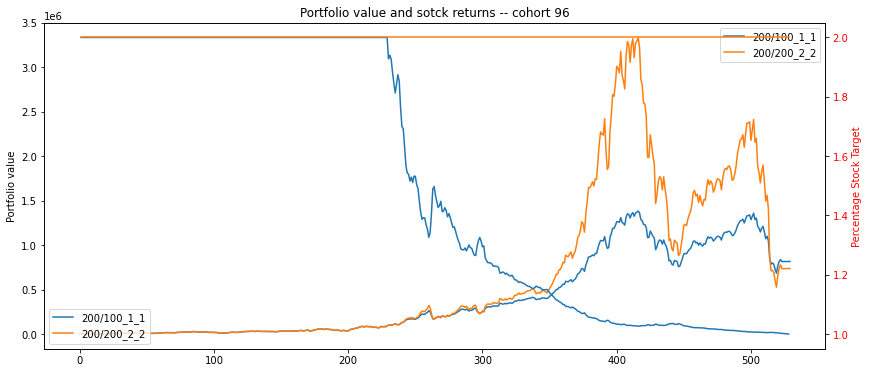

In [91]:
# plot portfolio value, stock returns, and percentage target of stocks

strategies = ['200/83_0.83_0.83', '200/100_1_1', '200/200_2_2'][1:3]

for cohort_num in results.cohort_num.unique()[:]:
    
    results2 = results.loc[((results.strategy.isin(strategies)) & 
                            (results.cohort_num==cohort_num)),
                       ['strategy', 'cohort_num','period_num', 'port_value', 'Monthly_real_stock_rate','perc_targ']]

    results3 = pd.pivot(results2, 
                        index=['period_num'], 
                        columns=['strategy'], 
                        values=['port_value', 'Monthly_real_stock_rate','perc_targ'])
    
    results3.loc[0, results3.columns.get_level_values(0)=='perc_targ'] = np.nan

    fig, ax = plt.subplots()

    # Plot linear sequence, and set tick labels to the same color
    ax.plot(results3.loc[:, results3.columns.get_level_values(0)=='port_value']) #, color='red')
    ax.tick_params(axis='y')#, labelcolor='red')
    ax.set_ylabel('Portfolio value')
    ax.legend(results3.loc[:,results3.columns.get_level_values(0)=='port_value'].columns.get_level_values(1).values)
    ax.set_title("Portfolio value and sotck returns -- cohort " + str(cohort_num))

    # Generate a new Axes instance, on the twin-X axes (same position)
#     ax2 = ax.twinx()
#     # Plot exponential sequence, set scale to logarithmic and change tick color
#     ax2.plot(results3.loc[:, results3.columns.get_level_values(0)=='Monthly_real_stock_rate'].rolling(48).mean(), color='green')
#     ax2.tick_params(axis='y', labelcolor='green')
#     ax2.set_ylabel('Stock returns', color='green')
    
    # Generate a new Axes instance, on the twin-X axes (same position)
    ax3 = ax.twinx()
    # Plot exponential sequence, set scale to logarithmic and change tick color
    ax3.plot(results3.loc[:, results3.columns.get_level_values(0)=='perc_targ'])#, color='red')
    ax3.tick_params(axis='y', labelcolor='red')
    ax3.set_ylabel('Percentage Stock Target', color='red')
    ax3.legend(results3.loc[:,results3.columns.get_level_values(0)=='perc_targ'].columns.get_level_values(1).values)

    plt.show()